In [1]:
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import random
from torch.autograd import Variable
from matplotlib import pyplot as plt
import seaborn as sns
from torch import nn
from collections import OrderedDict

import torchmetrics

import optuna

from tqdm import tqdm

import time
import plotly.graph_objects as go
import os

/home/hudson/Unifei/TCC/codigos/EDPs_Neural_network/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from Loss import Loss
from Net import Net

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
def metricas(net, sol_eq, a, b):
    """Calcula a o erro médio quadrado e o erro médio
    absoluto de uma rede neural.

    Parameters
    ----------
    net : _type_
        Rede neural
    sol_eq : _type_
        Função da equação analítica
    a : int
        _description_
    b : int
        _description_

    Returns
    -------
    Tuple
        Erro médio quadrado e erro médio absoluto
    """
    xx = torch.linspace(0, a, 100)
    yy = torch.linspace(0, b, 100)

    xx, yy = torch.meshgrid(xx, yy, indexing='xy')

    xx = xx.reshape((xx.shape[0]**2, 1))
    yy = yy.reshape((yy.shape[0]**2, 1))

    sol = sol_eq(xx, yy)
    prev = net.predict(torch.cat([xx, yy], axis=1))

    return torchmetrics.functional.mean_squared_error(sol, prev),\
           torchmetrics.functional.mean_absolute_error(sol, prev)

In [5]:
def plot_solucao_erro_l2(net, sol_eq, a, b):
    xx = torch.linspace(0, a, 100)
    yy = torch.linspace(0, b, 100)

    xx, yy = torch.meshgrid(xx, yy, indexing='xy')

    xx = xx.reshape((xx.shape[0]**2, 1))
    yy = yy.reshape((yy.shape[0]**2, 1))

    sol = sol_eq(xx, yy)
    prev = net.predict(torch.cat([xx, yy], axis=1))

    prev = prev.reshape((100, 100))
    sol = sol.reshape((100, 100))
    xx = xx.reshape((100, 100))
    yy = yy.reshape((100, 100))

    #plot
    fig1, ax = plt.subplots(1, 2, figsize=(20,7))

    img1 = ax[0].pcolor(xx.numpy(), yy.numpy(), sol.numpy(), vmin=sol.min(), vmax=sol.max())
    fig1.colorbar(img1, ax=ax[0])
    ax[0].set_title('Solução Analítica')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    img2 = ax[1].pcolor(xx.numpy(), yy.numpy(), prev.numpy(), vmin=sol.min(), vmax=sol.max())
    fig1.colorbar(img2, ax=ax[1])

    ax[1].set_title('Solução numérica obtida pela rede neural1')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    #plt.show()

    # Plot erro L2
    fig, ax = plt.subplots(1, 1, figsize=(7,5))

    img1 = ax.pcolor(xx.numpy(), yy.numpy(), abs(prev.numpy() - sol.numpy()))
    fig.colorbar(img1, ax=ax)
    ax.set_title('Erro L2')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #plt.show()

    return fig1, fig


# Treino

## Onda 2

In [6]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 3
b = 2
# Calor
a = 40
b = 10
# Onda 2
a = 1
b = 1
x = np.random.uniform(0,a, size=L) ##
t = np.random.uniform(0,b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

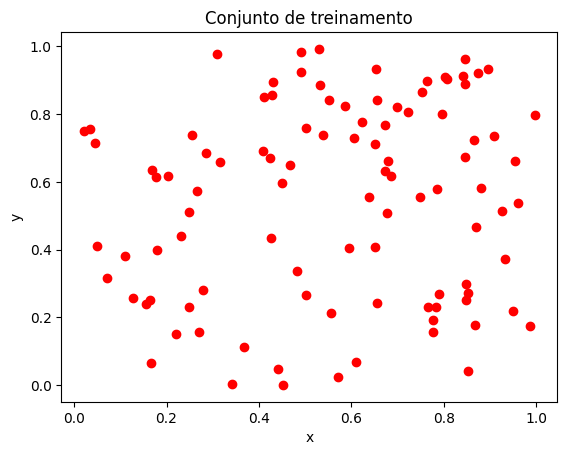

In [7]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [8]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Experimento 1

In [10]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=10,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOnda2(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [11]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 1.7735309732614757
Epoch 2000, Loss 0.04838330544893209
Epoch 3000, Loss 0.01989981160101599
Epoch 4000, Loss 0.012239973180720216
Epoch 5000, Loss 0.009132842275824796
Epoch 6000, Loss 0.007247021007069017
Epoch 7000, Loss 0.018262689548373148
Epoch 8000, Loss 0.005044354823388223
Epoch 9000, Loss 0.004390851094593246
Epoch 10000, Loss 0.004174186164815732
Epoch 11000, Loss 0.004105164842049442
Epoch 12000, Loss 0.0031348672881141904
Epoch 13000, Loss 0.003219432537703484
Epoch 14000, Loss 0.003108280401232205
Epoch 15000, Loss 0.00260360724146534
Epoch 16000, Loss 0.002230918323217938
Epoch 17000, Loss 0.013152197397206558
Epoch 18000, Loss 0.002039687254487021
Epoch 19000, Loss 0.0020277348162596313
Epoch 20000, Loss 0.0017198665983197063
Epoch 21000, Loss 0.0016477429320752017
Epoch 22000, Loss 0.009751711455030497
Epoch 23000, Loss 0.0066374970263915044
Epoch 24000, Loss 0.0013819128481368658
Epoch 25000, Loss 0.001529914422869457
Epoch 26000, Loss 0.0012733503756

In [12]:
metricas(net, Loss.solucao_onda_2, a, b)

(tensor(1.6908e-06), tensor(0.0011))

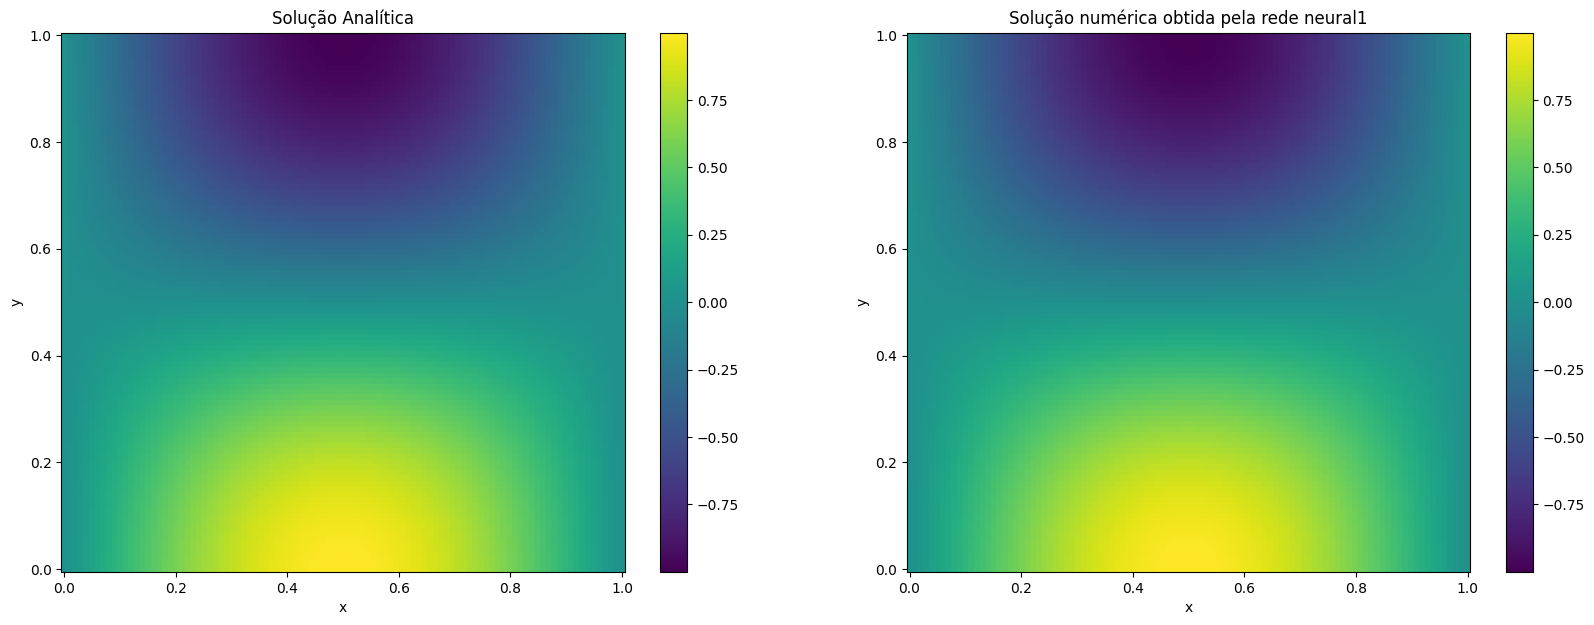

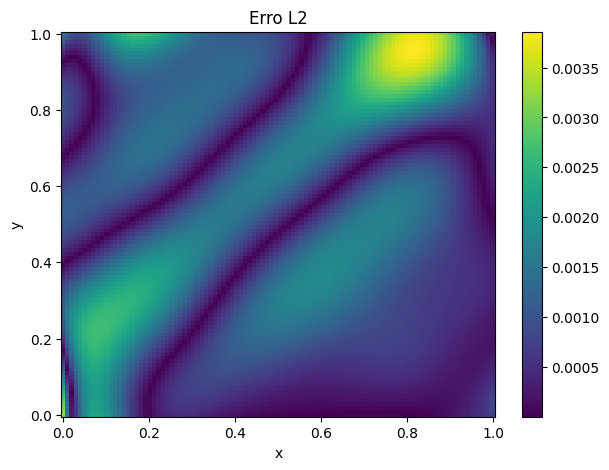

In [13]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda_2, a, b)

### Experimento 2

In [14]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=20,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOnda2(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [15]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.04147593492325905
Epoch 2000, Loss 0.01406869260406314
Epoch 3000, Loss 0.007654179530806317
Epoch 4000, Loss 0.005238931573508918
Epoch 5000, Loss 0.004203782879103583
Epoch 6000, Loss 0.0034632864300050106
Epoch 7000, Loss 0.0029298920237630184
Epoch 8000, Loss 0.002532726653946248
Epoch 9000, Loss 0.006022258886666569
Epoch 10000, Loss 0.0019880123526473496
Epoch 11000, Loss 0.0017930815934015468
Epoch 12000, Loss 0.0016256856267370108
Epoch 13000, Loss 0.0015039971863915432
Epoch 14000, Loss 0.0013681241042245507
Epoch 15000, Loss 0.0012641697553413607
Epoch 16000, Loss 0.0011694215783502793
Epoch 17000, Loss 0.002832142161214402
Epoch 18000, Loss 0.0010250167046392707
Epoch 19000, Loss 0.0009718506596053567
Epoch 20000, Loss 0.0009241520102782659
Epoch 21000, Loss 0.0008433404807804307
Epoch 22000, Loss 0.0008000886923541775
Epoch 23000, Loss 0.00255861773818872
Epoch 24000, Loss 0.016400525012828706
Epoch 25000, Loss 0.000742255806127993
Epoch 26000, Loss 0.000

In [16]:
metricas(net, Loss.solucao_onda_2, a, b)

(tensor(1.4949e-06), tensor(0.0009))

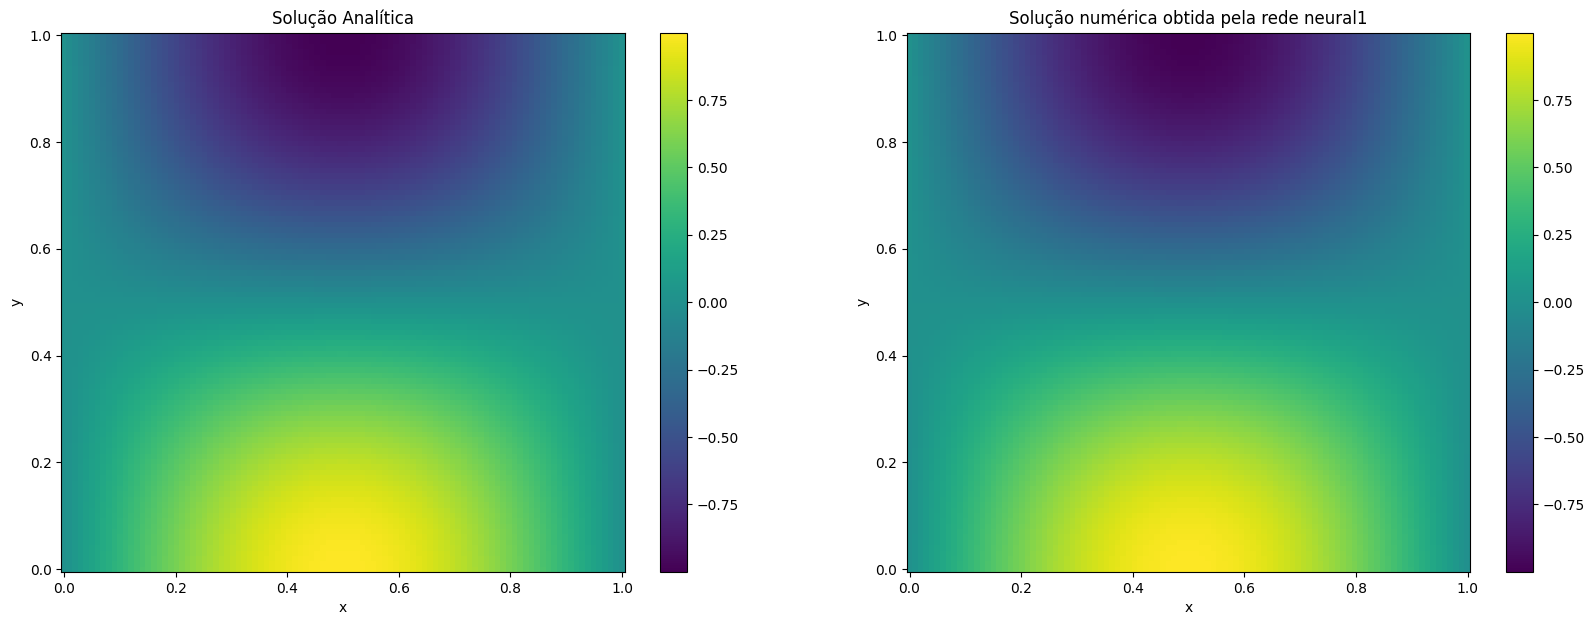

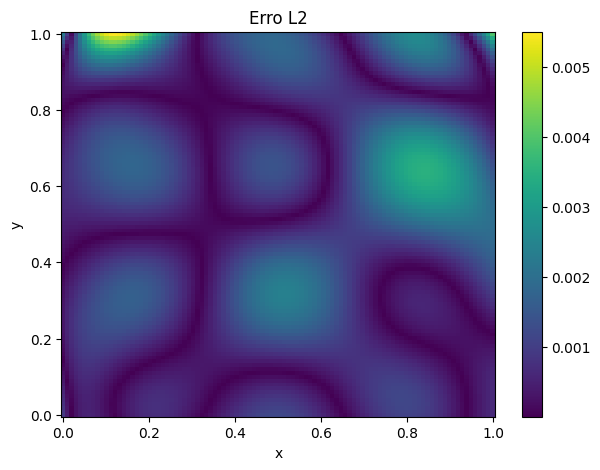

In [17]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda_2, a, b)

### Experimento 3

In [18]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=30,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOnda2(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [19]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.071669896776891
Epoch 2000, Loss 0.015099160481307118
Epoch 3000, Loss 0.00716215059025448
Epoch 4000, Loss 0.009661426403314795
Epoch 5000, Loss 0.003135502380249654
Epoch 6000, Loss 0.0022823311216793435
Epoch 7000, Loss 0.0019648957830943016
Epoch 8000, Loss 0.0016374912114857326
Epoch 9000, Loss 0.01596430757078033
Epoch 10000, Loss 0.07845910526957846
Epoch 11000, Loss 0.0012539868867635692
Epoch 12000, Loss 0.1091303511744463
Epoch 13000, Loss 0.01208788764123912
Epoch 14000, Loss 0.005455147445250115
Epoch 15000, Loss 0.001095438070749059
Epoch 16000, Loss 0.001643149362663669
Epoch 17000, Loss 0.0009607029488732481
Epoch 18000, Loss 0.0013664505628238424
Epoch 19000, Loss 0.0010353713045401904
Epoch 20000, Loss 0.0008694419020344813
Epoch 21000, Loss 0.00463995996644185
Epoch 22000, Loss 0.0034399795618403643
Epoch 23000, Loss 0.0009924701623398417
Epoch 24000, Loss 0.004836599817005326
Epoch 25000, Loss 0.0007639857767579623
Epoch 26000, Loss 0.0013427104813

In [20]:
metricas(net, Loss.solucao_onda_2, a, b)

(tensor(1.8848e-06), tensor(0.0011))

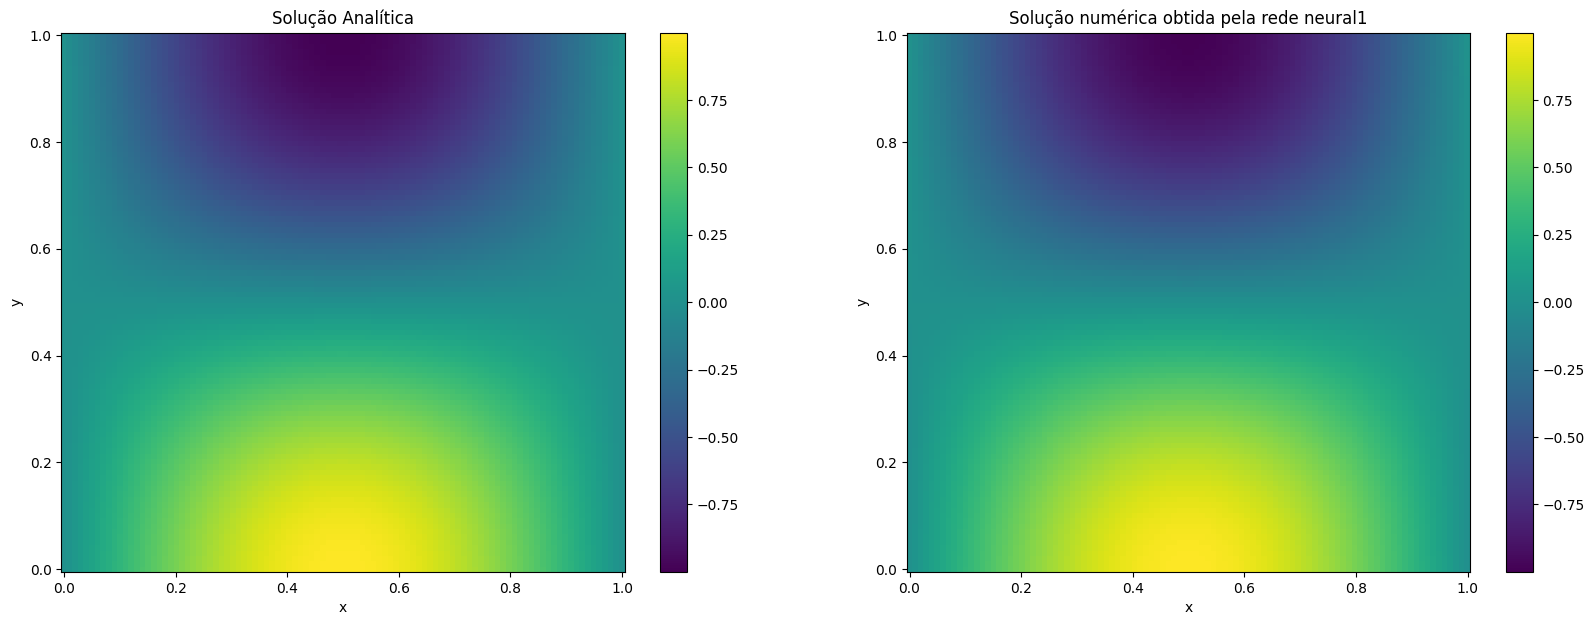

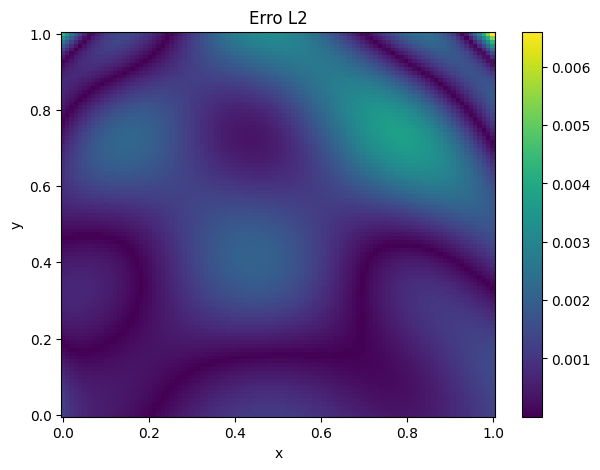

In [21]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda_2, a, b)

## Onda em uma corda

In [22]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 40
b = 1

x = np.random.uniform(0, a, size=L) ##
t = np.random.uniform(0, b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

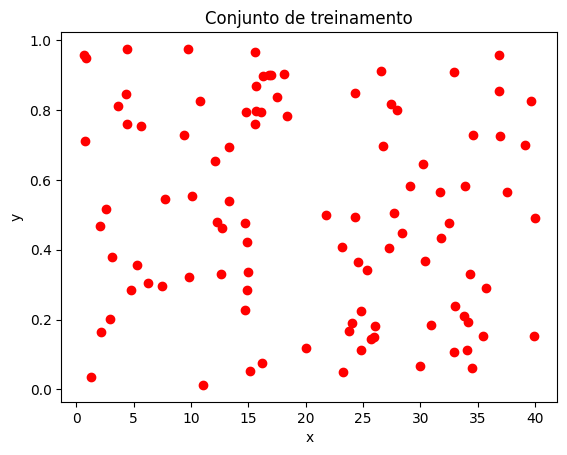

In [23]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [24]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Experimento 1

In [26]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=10,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOndaCorda(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [27]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 78.23362765319784
Epoch 2000, Loss 11.356730864373406
Epoch 3000, Loss 3.505841439108558
Epoch 4000, Loss 1.6237260802717397
Epoch 5000, Loss 0.6770198410676957
Epoch 6000, Loss 0.343120622281782
Epoch 7000, Loss 0.22126759048833483
Epoch 8000, Loss 0.1787993352438832
Epoch 9000, Loss 0.12422203816603437
Epoch 10000, Loss 0.09700495710061972
Epoch 11000, Loss 0.07874445510441817
Epoch 12000, Loss 0.0683153159376173
Epoch 13000, Loss 0.05528047373888753
Epoch 14000, Loss 0.047304071020645766
Epoch 15000, Loss 0.041380851167982444
Epoch 16000, Loss 0.03724695491674902
Epoch 17000, Loss 0.031801665361451736
Epoch 18000, Loss 0.028471323143267294
Epoch 19000, Loss 0.025677990368679342
Epoch 20000, Loss 0.023305950135217954
Epoch 21000, Loss 0.021269069733740757
Epoch 22000, Loss 0.019578760512122963
Epoch 23000, Loss 0.018060115330637998
Epoch 24000, Loss 0.021074452218791142
Epoch 25000, Loss 0.028275658963045007
Epoch 26000, Loss 0.03334539648959801
Epoch 27000, Loss 0.1

In [28]:
metricas(net, Loss.solucao_onda_corda, a, b)

(tensor(0.0158), tensor(0.0439))

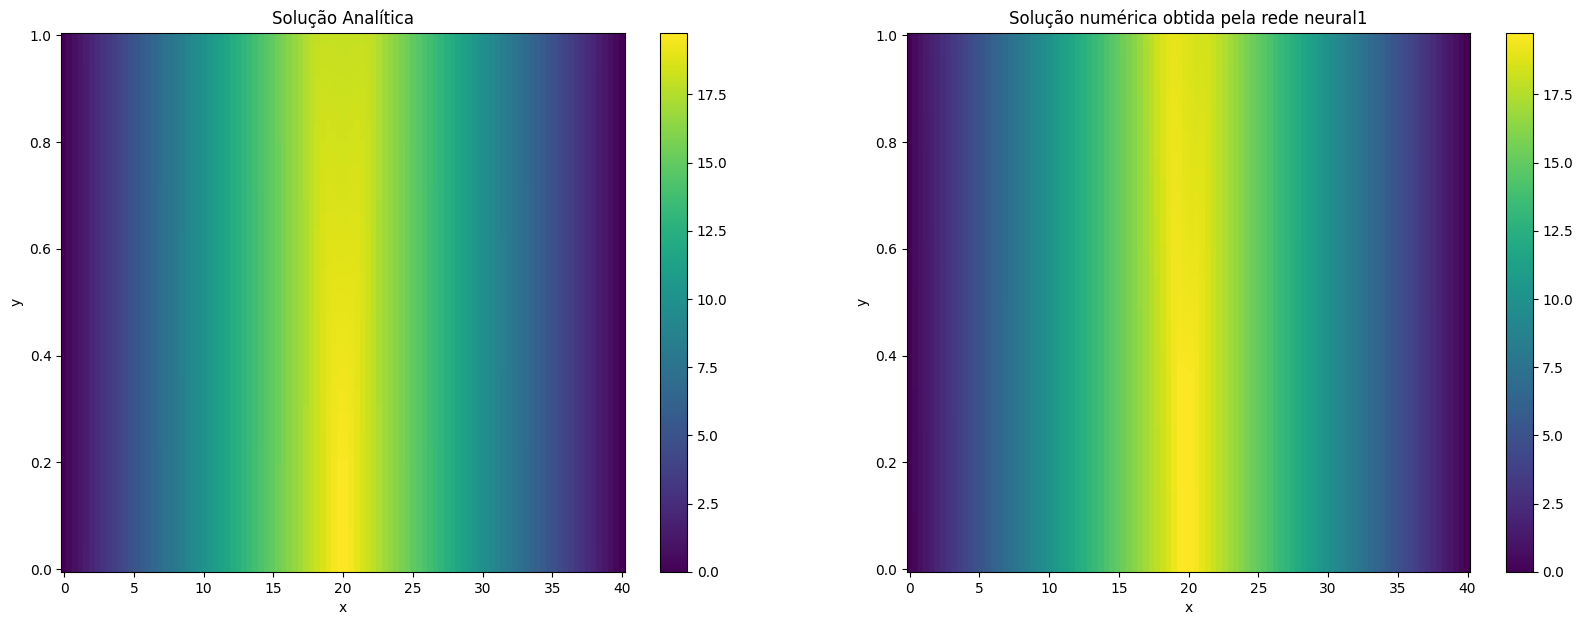

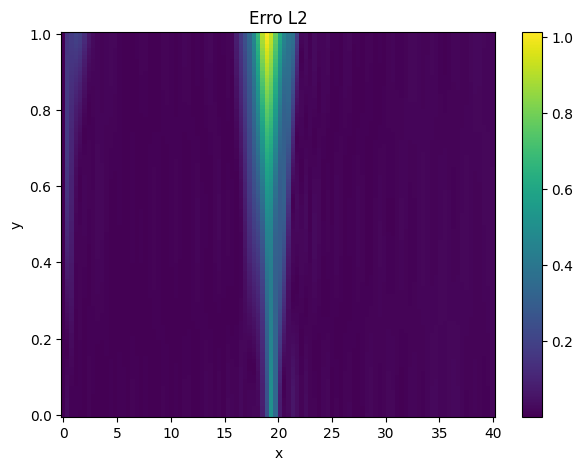

In [29]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda_corda, a, b)

### Experimento 2

In [30]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=20,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOndaCorda(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [31]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 9.801242325591964
Epoch 2000, Loss 2.9593935676469787
Epoch 3000, Loss 1.4972516718490203
Epoch 4000, Loss 0.939048826444082
Epoch 5000, Loss 0.46252620914989245
Epoch 6000, Loss 0.08090467447561547
Epoch 7000, Loss 0.01801435418077985
Epoch 8000, Loss 0.014149661005966598
Epoch 9000, Loss 0.006668481787865806
Epoch 10000, Loss 0.012776037891646908
Epoch 11000, Loss 0.004112512780429794
Epoch 12000, Loss 0.01332244121626165
Epoch 13000, Loss 0.003487750879122465
Epoch 14000, Loss 0.0026509916761356125
Epoch 15000, Loss 0.0023419981874334846
Epoch 16000, Loss 0.0021212702128079624
Epoch 17000, Loss 0.007016184316208773
Epoch 18000, Loss 0.0037880041948372884
Epoch 19000, Loss 0.025568502918299665
Epoch 20000, Loss 0.0023404027904294095
Epoch 21000, Loss 0.001533487728654958
Epoch 22000, Loss 0.0034830894566685697
Epoch 23000, Loss 0.007457341158223928
Epoch 24000, Loss 0.0056058787983169316
Epoch 25000, Loss 0.001980705953745741
Epoch 26000, Loss 0.005823943278202858
Ep

In [32]:
metricas(net, Loss.solucao_onda_corda, a, b)

(tensor(0.0124), tensor(0.0383))

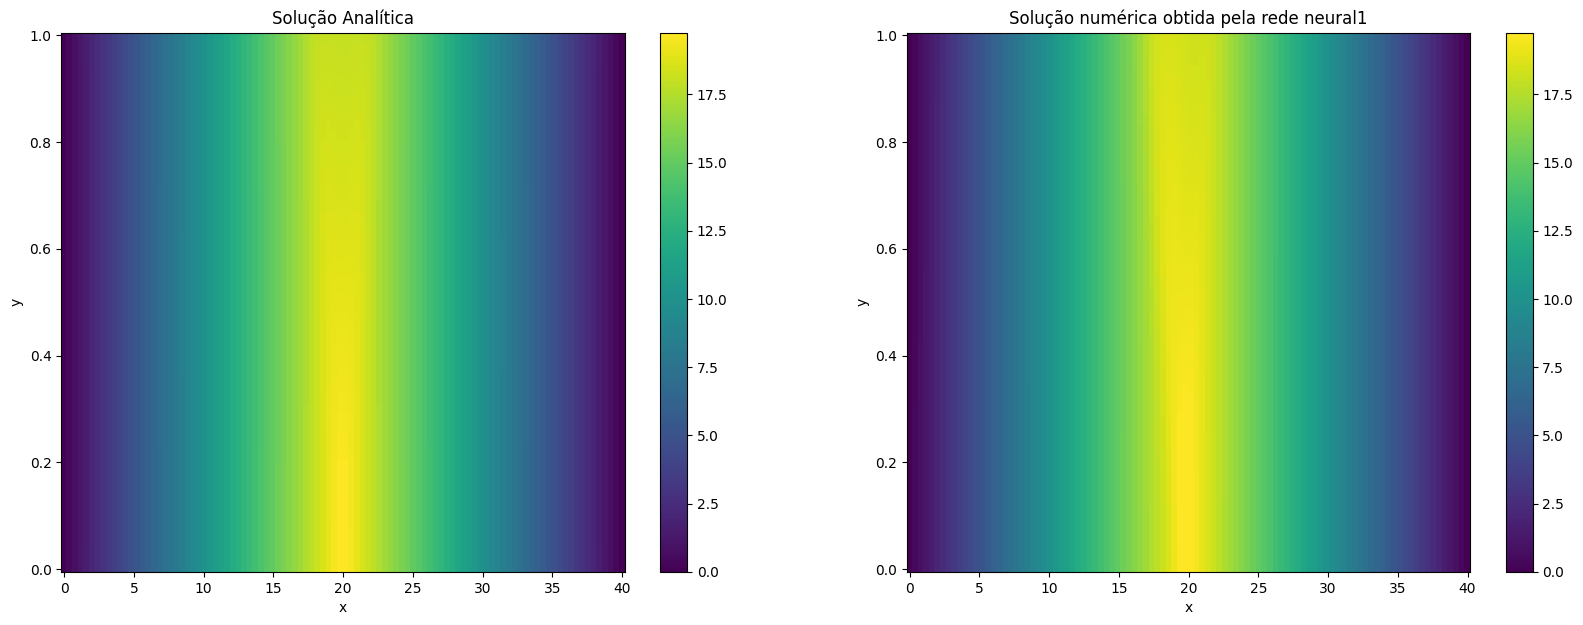

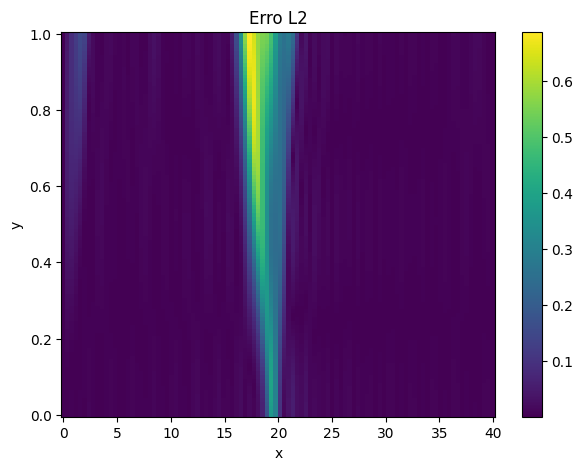

In [33]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda_corda, a, b)

### Experimento 3

In [34]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=30,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOndaCorda(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [35]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 3.2908121262889347
Epoch 2000, Loss 1.0710850110824193
Epoch 3000, Loss 0.5066401721511647
Epoch 4000, Loss 0.22286310353964706
Epoch 5000, Loss 0.17537171224738868
Epoch 6000, Loss 0.015371868530334865
Epoch 7000, Loss 0.004013462955397139
Epoch 8000, Loss 0.0027872616482595676
Epoch 9000, Loss 0.05688905718953452
Epoch 10000, Loss 0.003313462793600401
Epoch 11000, Loss 0.002149301438882917
Epoch 12000, Loss 0.0018099091825192286
Epoch 13000, Loss 0.001039168397438711
Epoch 14000, Loss 0.0010230952218202802
Epoch 15000, Loss 0.0053039346334773415
Epoch 16000, Loss 0.01871877552396399
Epoch 17000, Loss 0.0008477002714607487
Epoch 18000, Loss 0.0009513166716731765
Epoch 19000, Loss 0.000906317175233912
Epoch 20000, Loss 0.0013005688259970073
Epoch 21000, Loss 0.0005066318214354896
Epoch 22000, Loss 0.04670002339905973
Epoch 23000, Loss 0.0011233896952940136
Epoch 24000, Loss 0.00045782067739751726
Epoch 25000, Loss 0.003173810133206843
Epoch 26000, Loss 0.01970789929730

In [36]:
metricas(net, Loss.solucao_onda_corda, a, b)

(tensor(0.0048), tensor(0.0222))

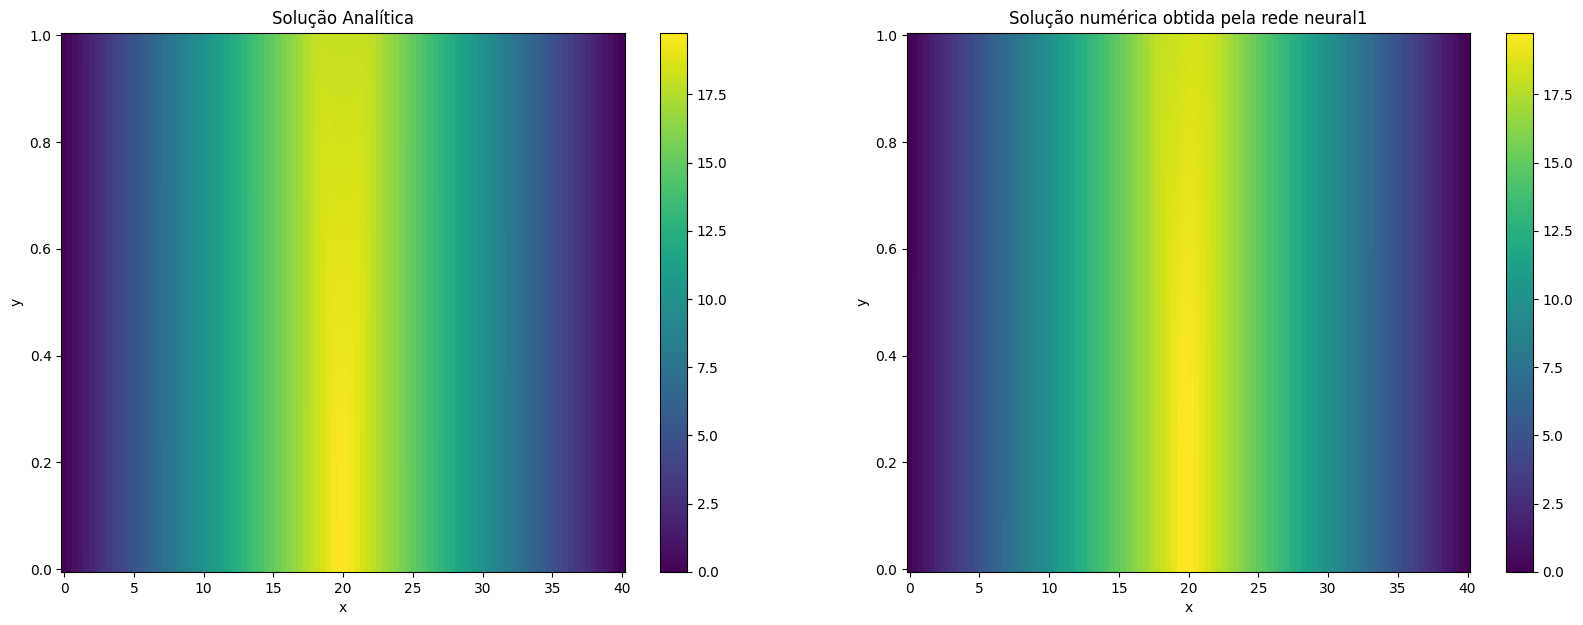

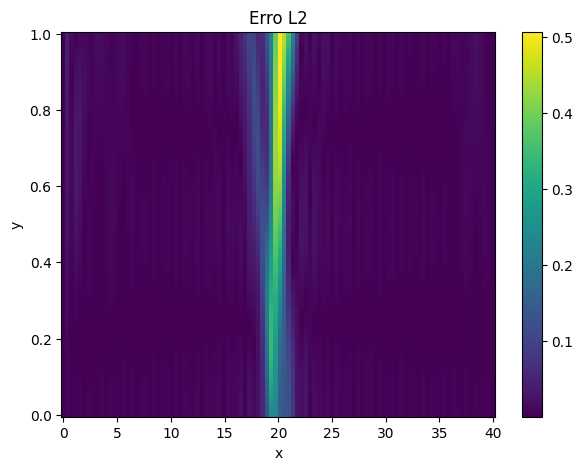

In [37]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda_corda, a, b)

## Onda 3

In [38]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 0.5
b = 0.5

x = np.random.uniform(0, a, size=L) ##
t = np.random.uniform(0, b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

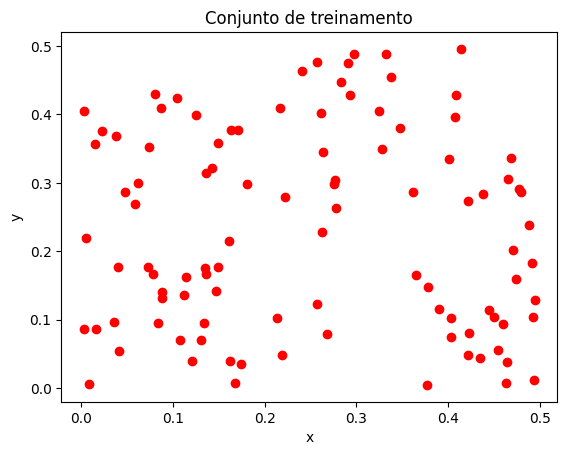

In [39]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [40]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Experimento 1

In [42]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=10,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOnda3(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [43]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 3.2554071718149498
Epoch 2000, Loss 0.12540533844585944
Epoch 3000, Loss 0.031037278029382255
Epoch 4000, Loss 0.0112806941830154
Epoch 5000, Loss 0.005514993297098508
Epoch 6000, Loss 0.0034416762096031207
Epoch 7000, Loss 0.003924029425021509
Epoch 8000, Loss 0.005591865707355824
Epoch 9000, Loss 0.004337604021239096
Epoch 10000, Loss 0.001245913204494446
Epoch 11000, Loss 0.0010757536262017253
Epoch 12000, Loss 0.0009369674064642732
Epoch 13000, Loss 0.001475851806015208
Epoch 14000, Loss 0.000752506811172145
Epoch 15000, Loss 0.0006797998876870447
Epoch 16000, Loss 0.0006461138972313283
Epoch 17000, Loss 0.0007030677228190728
Epoch 18000, Loss 0.01635386972253406
Epoch 19000, Loss 0.0004839361377963556
Epoch 20000, Loss 0.005229844683671443
Epoch 21000, Loss 0.00043553491673498584
Epoch 22000, Loss 0.0024052108204241605
Epoch 23000, Loss 0.000364920898964736
Epoch 24000, Loss 0.00034300740478420154
Epoch 25000, Loss 0.0003225384574865583
Epoch 26000, Loss 0.0003036

In [44]:
metricas(net, Loss.solucao_onda_3, a, b)

(tensor(5.4645e-08), tensor(0.0001))

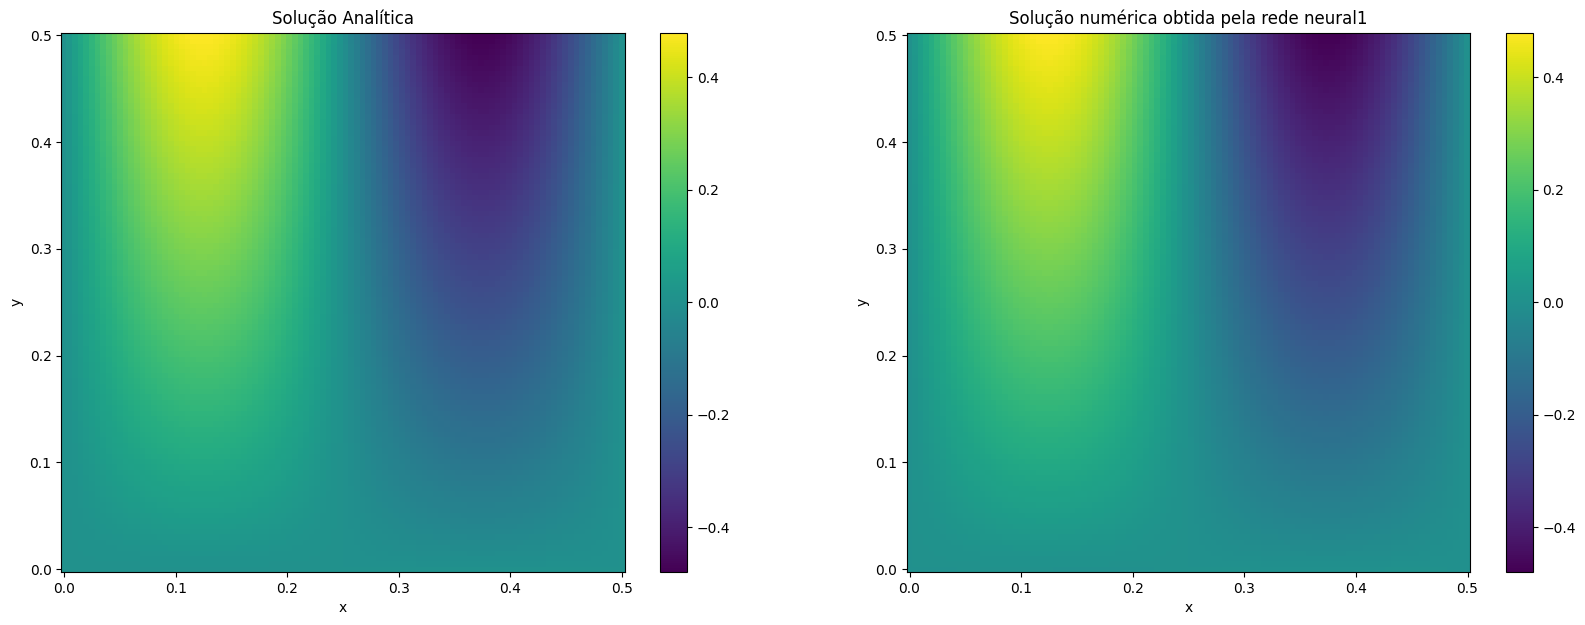

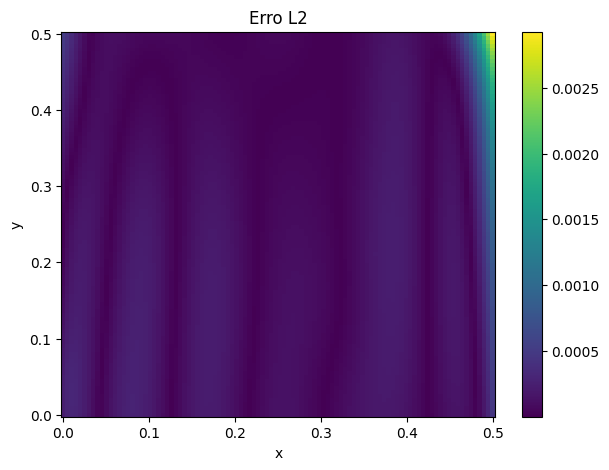

In [45]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda_3, a, b)

### Experimento 2

In [46]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=20,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOnda3(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [47]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.04204028746955677
Epoch 2000, Loss 0.0072224057835684466
Epoch 3000, Loss 0.0039184725403116575
Epoch 4000, Loss 0.006179770830819874
Epoch 5000, Loss 0.002678907686087387
Epoch 6000, Loss 0.0016475104224877883
Epoch 7000, Loss 0.001367832673636543
Epoch 8000, Loss 0.0011531879724629782
Epoch 9000, Loss 0.005038436002702119
Epoch 10000, Loss 0.0020125274705560833
Epoch 11000, Loss 0.004609476591713853
Epoch 12000, Loss 0.0007229239471271798
Epoch 13000, Loss 0.000803048413661896
Epoch 14000, Loss 0.0006875394444556021
Epoch 15000, Loss 0.0005991986984787718
Epoch 16000, Loss 0.0013549764665047714
Epoch 17000, Loss 0.002352908632422712
Epoch 18000, Loss 0.005318117012781197
Epoch 19000, Loss 0.003843161607442301
Epoch 20000, Loss 0.0004361273742428935
Epoch 21000, Loss 0.0008839508069591953
Epoch 22000, Loss 0.0017225340851316831
Epoch 23000, Loss 0.0019353153730810556
Epoch 24000, Loss 0.0008081665047101853
Epoch 25000, Loss 0.0007570878284761267
Epoch 26000, Loss 0.

In [48]:
metricas(net, Loss.solucao_onda_3, a, b)

(tensor(3.7794e-07), tensor(0.0004))

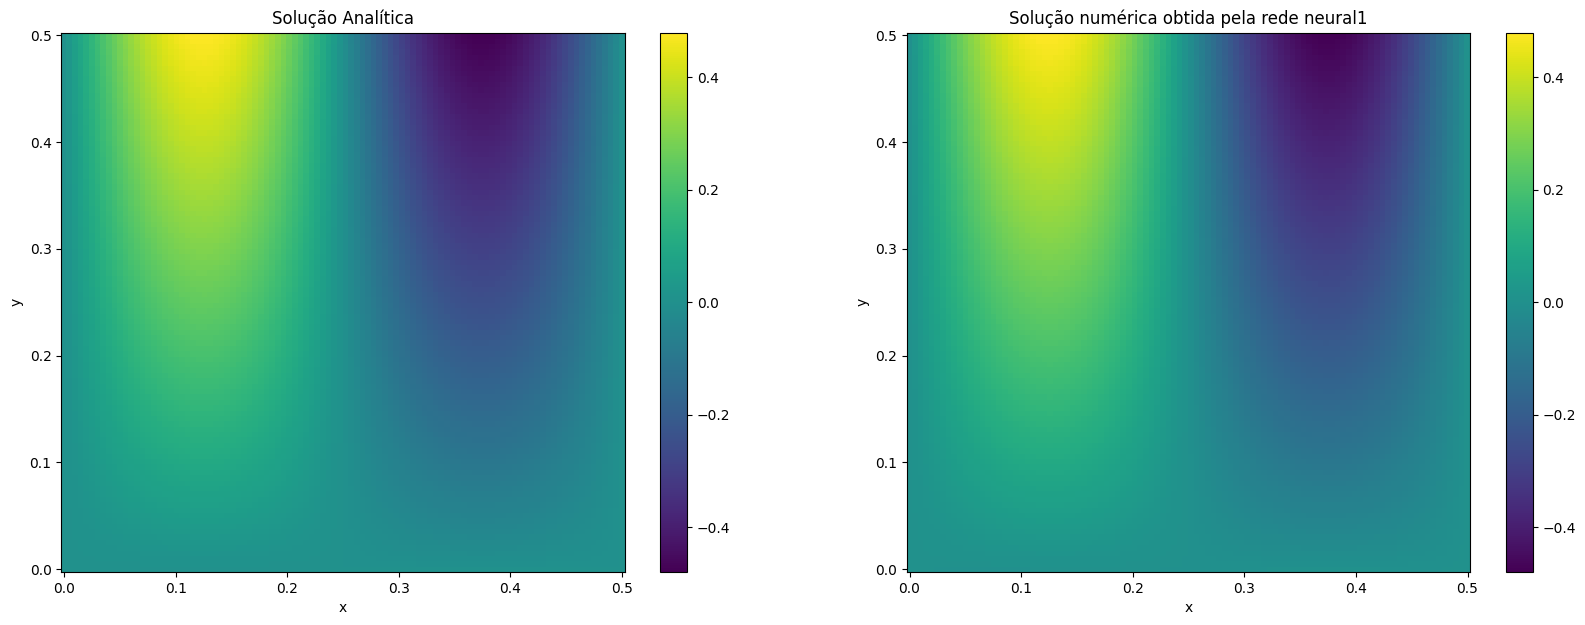

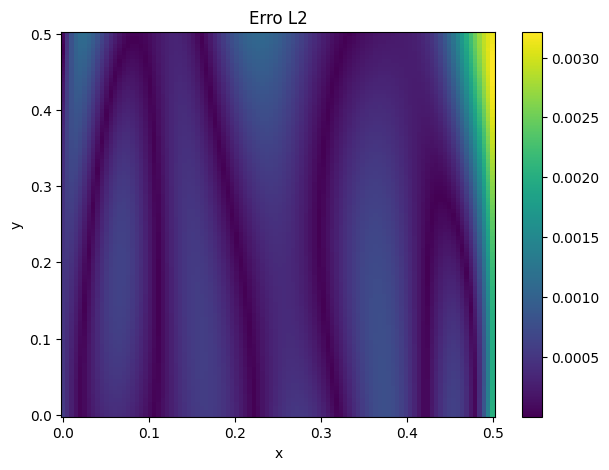

In [49]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda_3, a, b)

### Experimento 3

In [50]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=30,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOnda3(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [51]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.029599810300273775
Epoch 2000, Loss 0.010825824819540518
Epoch 3000, Loss 0.001629636591182212
Epoch 4000, Loss 0.00072056922957496
Epoch 5000, Loss 0.0015860109566531516
Epoch 6000, Loss 0.006976441750449621
Epoch 7000, Loss 0.003541584040829508
Epoch 8000, Loss 0.001727372694814077
Epoch 9000, Loss 0.004578633167415929
Epoch 10000, Loss 0.0009839432699225276
Epoch 11000, Loss 0.019430411744741843
Epoch 12000, Loss 0.00043799891987995356
Epoch 13000, Loss 0.00035745442078902753
Epoch 14000, Loss 0.0045990821533748345
Epoch 15000, Loss 0.0007031258264302315
Epoch 16000, Loss 0.00011596259216309735
Epoch 17000, Loss 0.0021284624964141427
Epoch 18000, Loss 0.0019833542611323997
Epoch 19000, Loss 0.00020201682769607765
Epoch 20000, Loss 0.0002494139336013352
Epoch 21000, Loss 0.0009361498199838792
Epoch 22000, Loss 0.01519393651551038
Epoch 23000, Loss 0.0007650893966122534
Epoch 24000, Loss 0.004889720838745595
Epoch 25000, Loss 0.00026772017207539575
Epoch 26000, Loss

In [52]:
metricas(net, Loss.solucao_onda_3, a, b)

(tensor(5.3392e-07), tensor(0.0003))

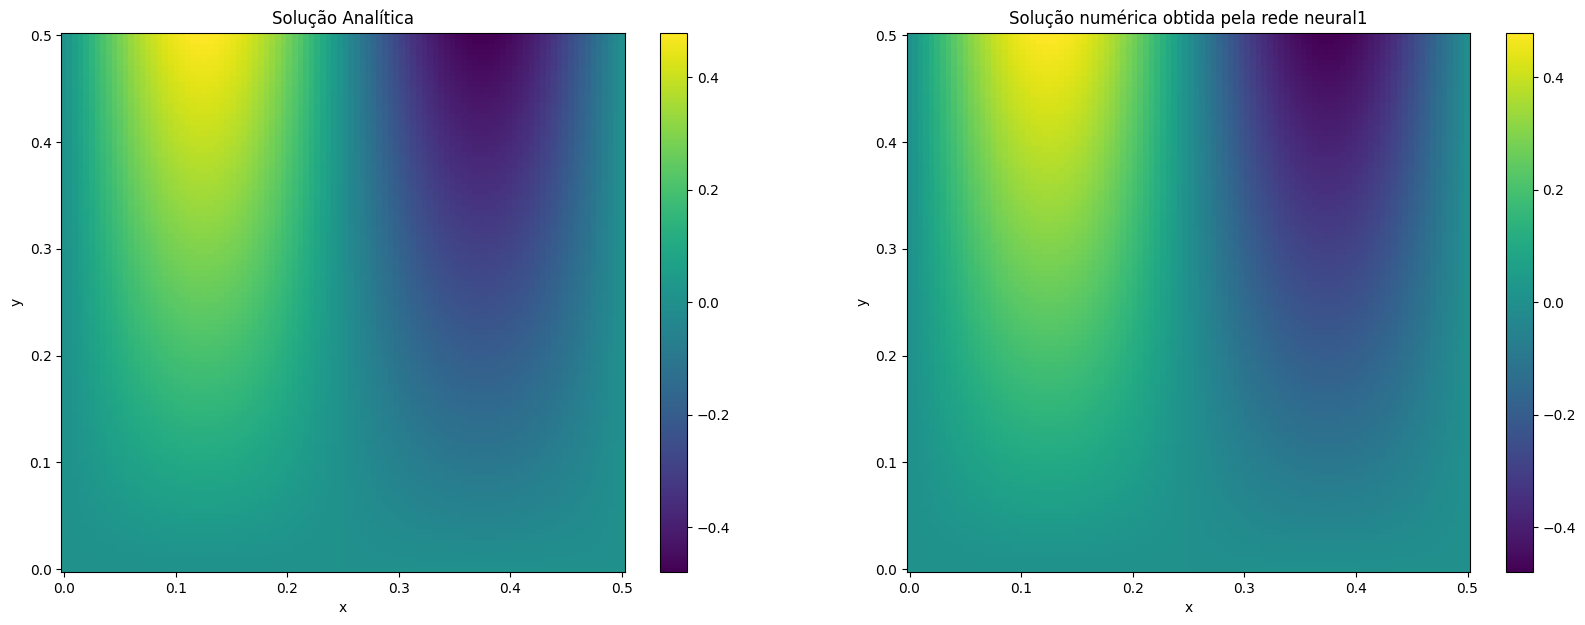

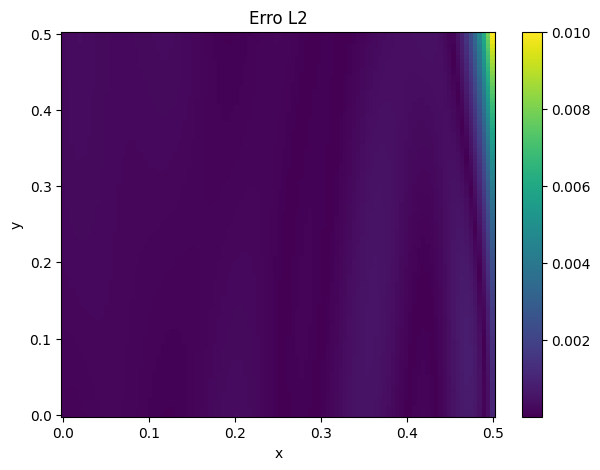

In [53]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda_3, a, b)

## Onda 4

In [54]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 1
b = 1

x = np.random.uniform(0, a, size=L) ##
t = np.random.uniform(0, b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

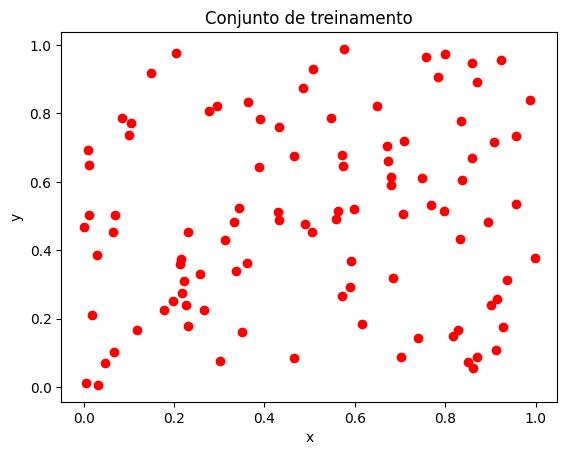

In [55]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [56]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Experimento 1

In [58]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=10,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOnda(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [59]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.5828918563541304
Epoch 2000, Loss 0.16614430177745998
Epoch 3000, Loss 0.08846142317972655
Epoch 4000, Loss 0.05285365076827811
Epoch 5000, Loss 0.03222402750078989
Epoch 6000, Loss 0.025254286827398283
Epoch 7000, Loss 0.015901583445601095
Epoch 8000, Loss 0.01717986931779997
Epoch 9000, Loss 0.010211646743284817
Epoch 10000, Loss 0.008751208293973918
Epoch 11000, Loss 0.015560381339909723
Epoch 12000, Loss 0.006863569747074495
Epoch 13000, Loss 0.0068523367542098965
Epoch 14000, Loss 0.006663073295997069
Epoch 15000, Loss 0.005702546213174144
Epoch 16000, Loss 0.004784924744254859
Epoch 17000, Loss 0.0045044617001523245
Epoch 18000, Loss 0.004145911898062451
Epoch 19000, Loss 0.003920828971953222
Epoch 20000, Loss 0.003951603549115922
Epoch 21000, Loss 0.003475891460125469
Epoch 22000, Loss 0.0032511120559402056
Epoch 23000, Loss 0.003082230610695741
Epoch 24000, Loss 0.008383816458044167
Epoch 25000, Loss 0.004068786152873885
Epoch 26000, Loss 0.06720565126512783


In [60]:
metricas(net, Loss.solucao_onda, a, b)

(tensor(3.9997), tensor(1.6141))

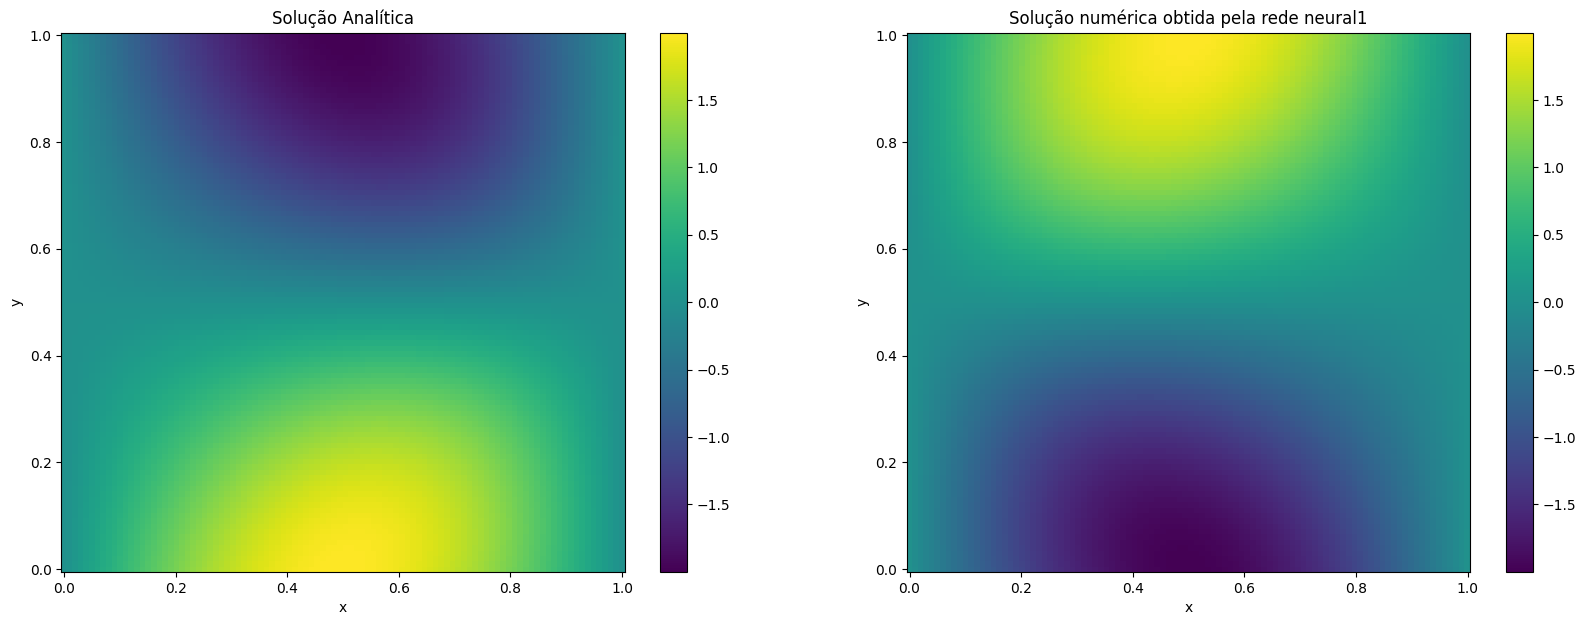

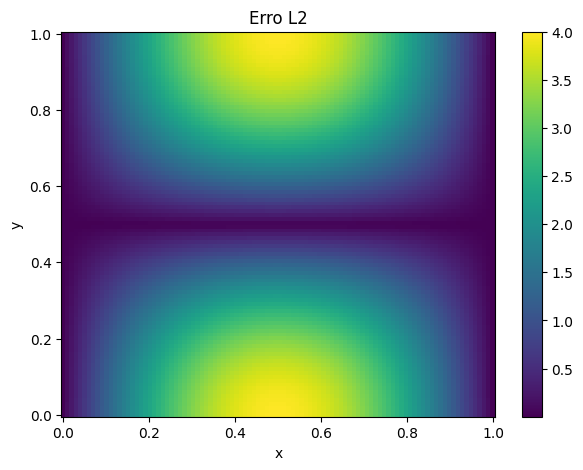

In [61]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda, a, b)

### Experimento 2

In [62]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=20,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOnda(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [63]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.14134418933940848
Epoch 2000, Loss 0.06713983618941435
Epoch 3000, Loss 0.2524996239852235
Epoch 4000, Loss 0.24379996377246563
Epoch 5000, Loss 0.018373039870429417
Epoch 6000, Loss 0.20330166616500583
Epoch 7000, Loss 0.013065330786819387
Epoch 8000, Loss 0.012953099067437513
Epoch 9000, Loss 0.020074412978955885
Epoch 10000, Loss 0.15624131633464589
Epoch 11000, Loss 0.008135536160742945
Epoch 12000, Loss 0.007784907645446031
Epoch 13000, Loss 0.034147062714920115
Epoch 14000, Loss 0.00843390799743892
Epoch 15000, Loss 0.01559464545578625
Epoch 16000, Loss 0.006387977407111577
Epoch 17000, Loss 0.00572425907812973
Epoch 18000, Loss 0.07251213975710442
Epoch 19000, Loss 0.004540712989701188
Epoch 20000, Loss 0.008188639601807731
Epoch 21000, Loss 0.032248641136187736
Epoch 22000, Loss 0.0044065324537344895
Epoch 23000, Loss 0.033975882994374006
Epoch 24000, Loss 0.2177457981984428
Epoch 25000, Loss 0.10215801765379005
Epoch 26000, Loss 0.003404084258810187
Epoch 27

In [64]:
metricas(net, Loss.solucao_onda, a, b)

(tensor(3.9988), tensor(1.6139))

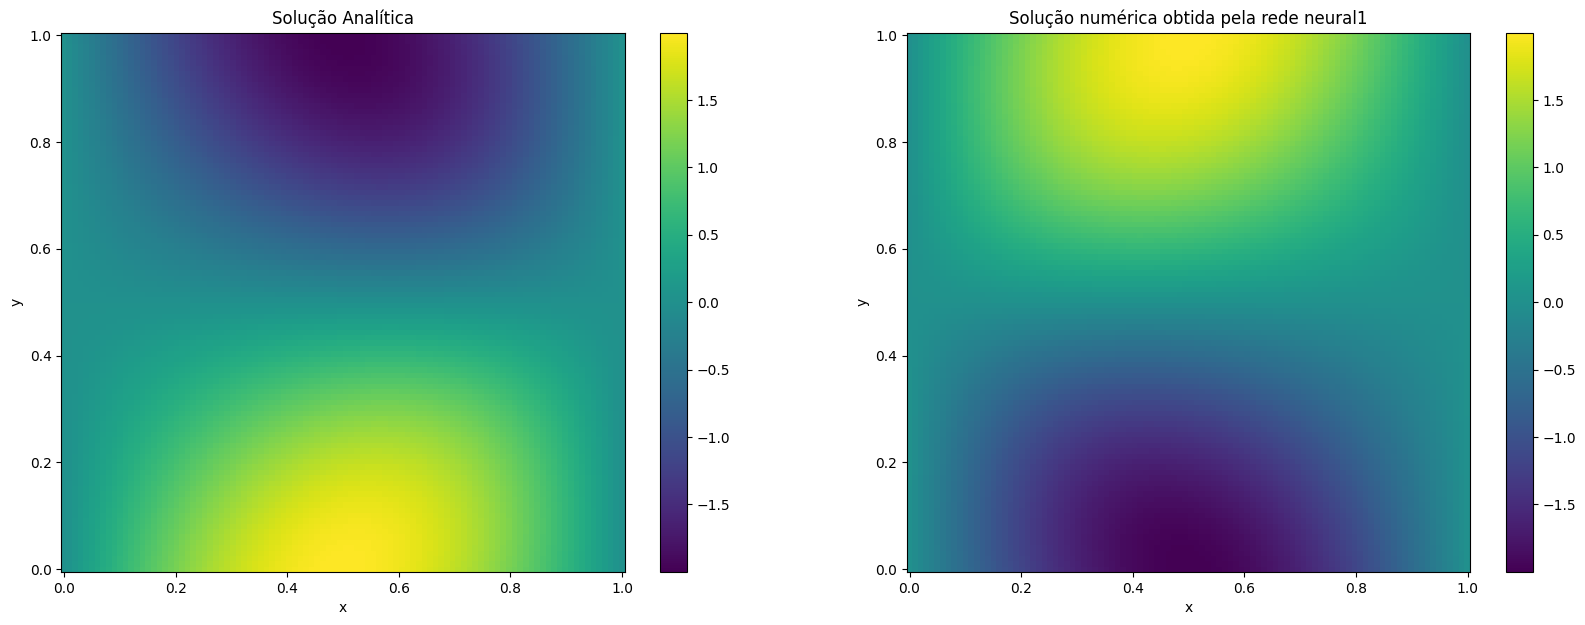

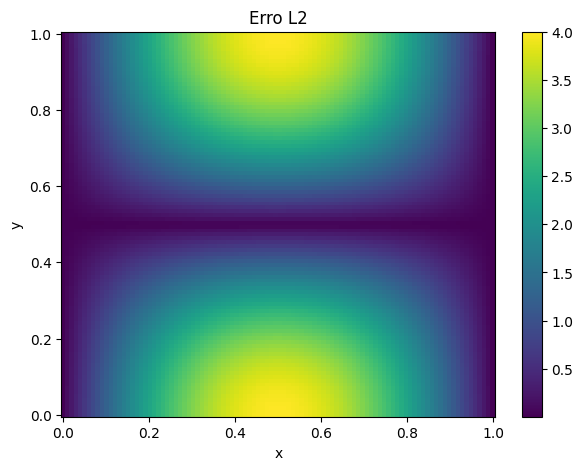

In [65]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda, a, b)

### Experimento 3

In [66]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=30,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossOnda(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [67]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.13445558331205104
Epoch 2000, Loss 0.05779085599729078
Epoch 3000, Loss 0.04402072124926398
Epoch 4000, Loss 0.019586994073183962
Epoch 5000, Loss 0.06335434944078012
Epoch 6000, Loss 0.14957749990168062
Epoch 7000, Loss 0.007730034073274649
Epoch 8000, Loss 0.010251929995851497
Epoch 9000, Loss 0.01021846789312163
Epoch 10000, Loss 0.12267563838379547
Epoch 11000, Loss 0.15089133462499857
Epoch 12000, Loss 0.16957964836784925
Epoch 13000, Loss 0.1805702500685702
Epoch 14000, Loss 0.005090232644339389
Epoch 15000, Loss 0.016803237173291484
Epoch 16000, Loss 0.006102717949830801
Epoch 17000, Loss 0.0052830598783297706
Epoch 18000, Loss 0.005445370995035025
Epoch 19000, Loss 0.009348909822880062
Epoch 20000, Loss 0.08248251288405115
Epoch 21000, Loss 0.04592177567974587
Epoch 22000, Loss 0.015192560105706134
Epoch 23000, Loss 0.03914984803443809
Epoch 24000, Loss 0.015520331307188487
Epoch 25000, Loss 0.007051284395204792
Epoch 26000, Loss 0.027772458036871527
Epoch 27

In [68]:
metricas(net, Loss.solucao_onda, a, b)

(tensor(4.0008), tensor(1.6145))

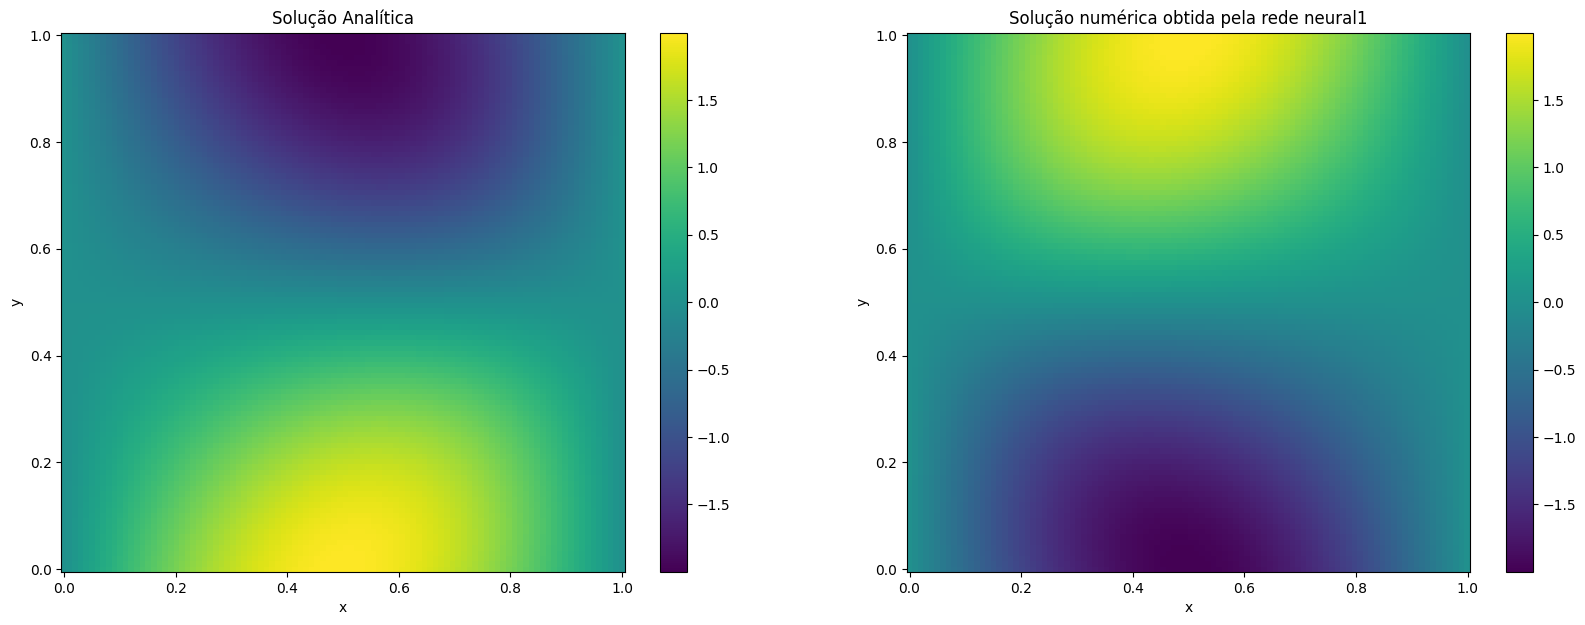

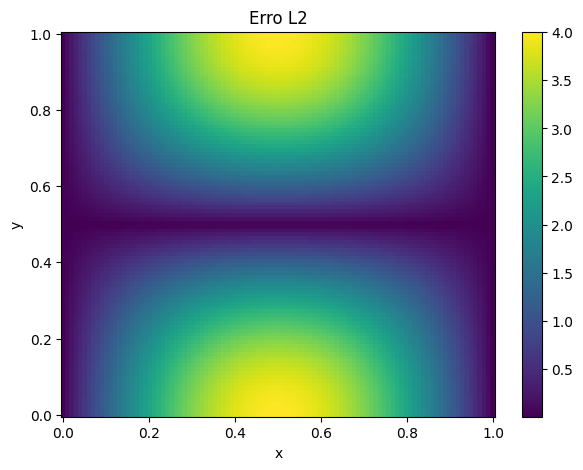

In [69]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_onda, a, b)

## Calor

In [70]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 3
b = 2

x = np.random.uniform(0, a, size=L) ##
t = np.random.uniform(0, b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

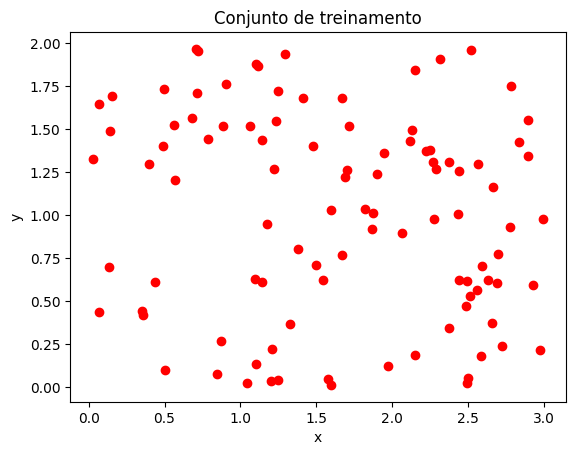

In [71]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [72]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Experimento 1

In [74]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=10,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossCalor(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [75]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.21061419705567175
Epoch 2000, Loss 0.029663598894993187
Epoch 3000, Loss 0.007399995686287718
Epoch 4000, Loss 0.002129137919473719
Epoch 5000, Loss 0.0009254957610993462
Epoch 6000, Loss 0.00051015744922199
Epoch 7000, Loss 0.0004946904432470624
Epoch 8000, Loss 0.00022308478883660925
Epoch 9000, Loss 0.00018203024506796876
Epoch 10000, Loss 0.0001381099749367167
Epoch 11000, Loss 0.00011484794914869553
Epoch 12000, Loss 0.0003040775682011026
Epoch 13000, Loss 8.447096617342146e-05
Epoch 14000, Loss 7.464876920938389e-05
Epoch 15000, Loss 6.922932818941237e-05
Epoch 16000, Loss 5.8092887987424245e-05
Epoch 17000, Loss 5.36291939578745e-05
Epoch 18000, Loss 4.798012478520345e-05
Epoch 19000, Loss 0.00043929276601508137
Epoch 20000, Loss 0.00016384489641003904
Epoch 21000, Loss 6.52722194836747e-05
Epoch 22000, Loss 3.3544773287898554e-05
Epoch 23000, Loss 3.122591074090983e-05
Epoch 24000, Loss 8.282580721889057e-05
Epoch 25000, Loss 0.0001610835817496508
Epoch 26000

In [76]:
metricas(net, Loss.solucao_equacao_calor, a, b)

(tensor(0.0272), tensor(0.0885))

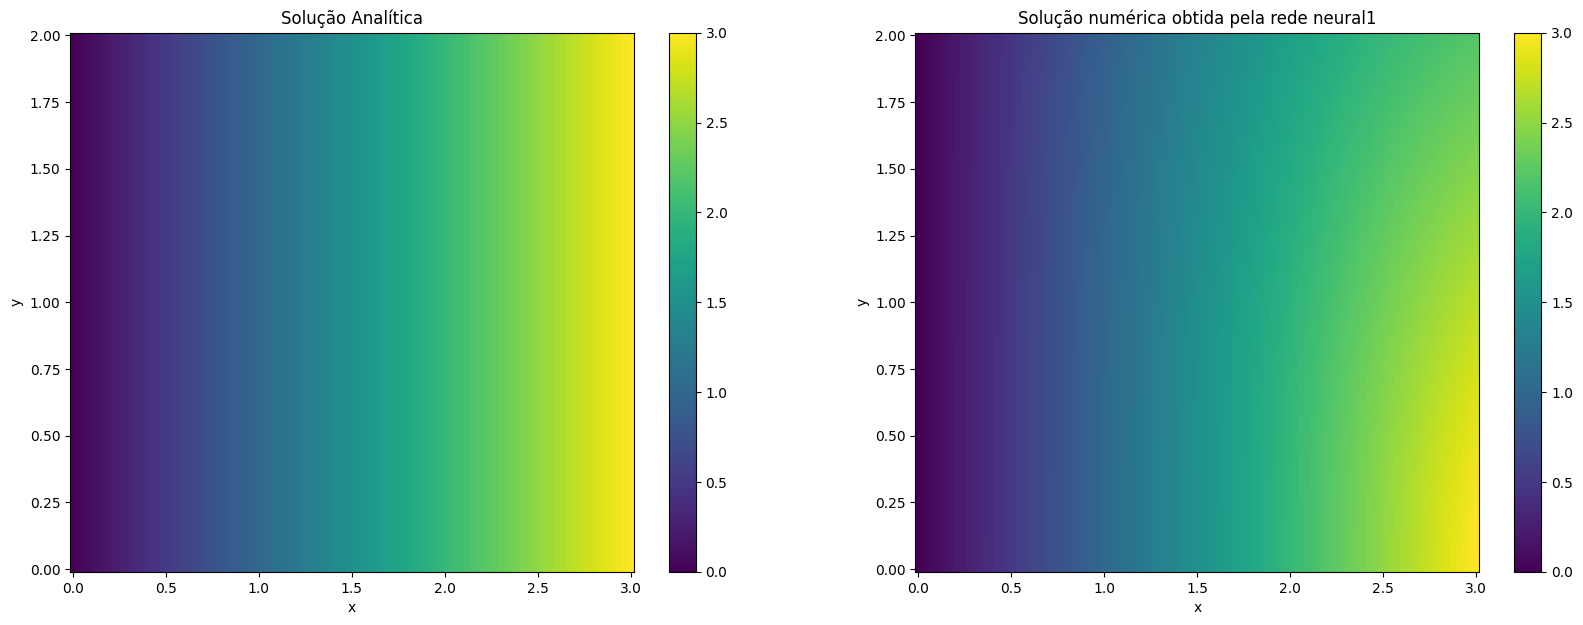

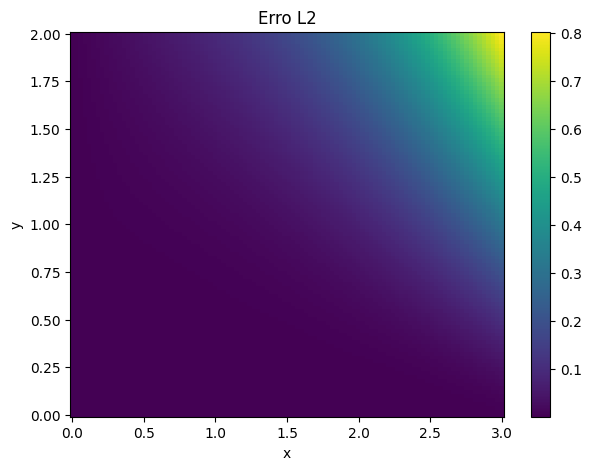

In [77]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_equacao_calor, a, b)

### Experimento 2

In [78]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=20,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossCalor(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [79]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.029486692217362845
Epoch 2000, Loss 0.005721589522359007
Epoch 3000, Loss 0.0025273661517611545
Epoch 4000, Loss 0.0007841753427391478
Epoch 5000, Loss 0.0004469222566167385
Epoch 6000, Loss 0.00022954134535655294
Epoch 7000, Loss 8.011804540153767e-05
Epoch 8000, Loss 5.786740934106793e-05
Epoch 9000, Loss 0.0003748586181769602
Epoch 10000, Loss 5.9778586951817684e-05
Epoch 11000, Loss 3.3424312701554595e-05
Epoch 12000, Loss 5.1871035915181363e-05
Epoch 13000, Loss 2.816863239974242e-05
Epoch 14000, Loss 2.155649075159403e-05
Epoch 15000, Loss 3.2262314385041455e-05
Epoch 16000, Loss 7.60377578959197e-05
Epoch 17000, Loss 1.8758488825389887e-05
Epoch 18000, Loss 0.0002888678564171107
Epoch 19000, Loss 5.0642534243030525e-05
Epoch 20000, Loss 0.00012908143883601252
Epoch 21000, Loss 0.00017128122695208217
Epoch 22000, Loss 3.106141679836797e-05
Epoch 23000, Loss 0.0005127183311109302
Epoch 24000, Loss 1.3463705076718139e-05
Epoch 25000, Loss 1.138770724578415e-05
Ep

In [80]:
metricas(net, Loss.solucao_equacao_calor, a, b)

(tensor(0.0094), tensor(0.0522))

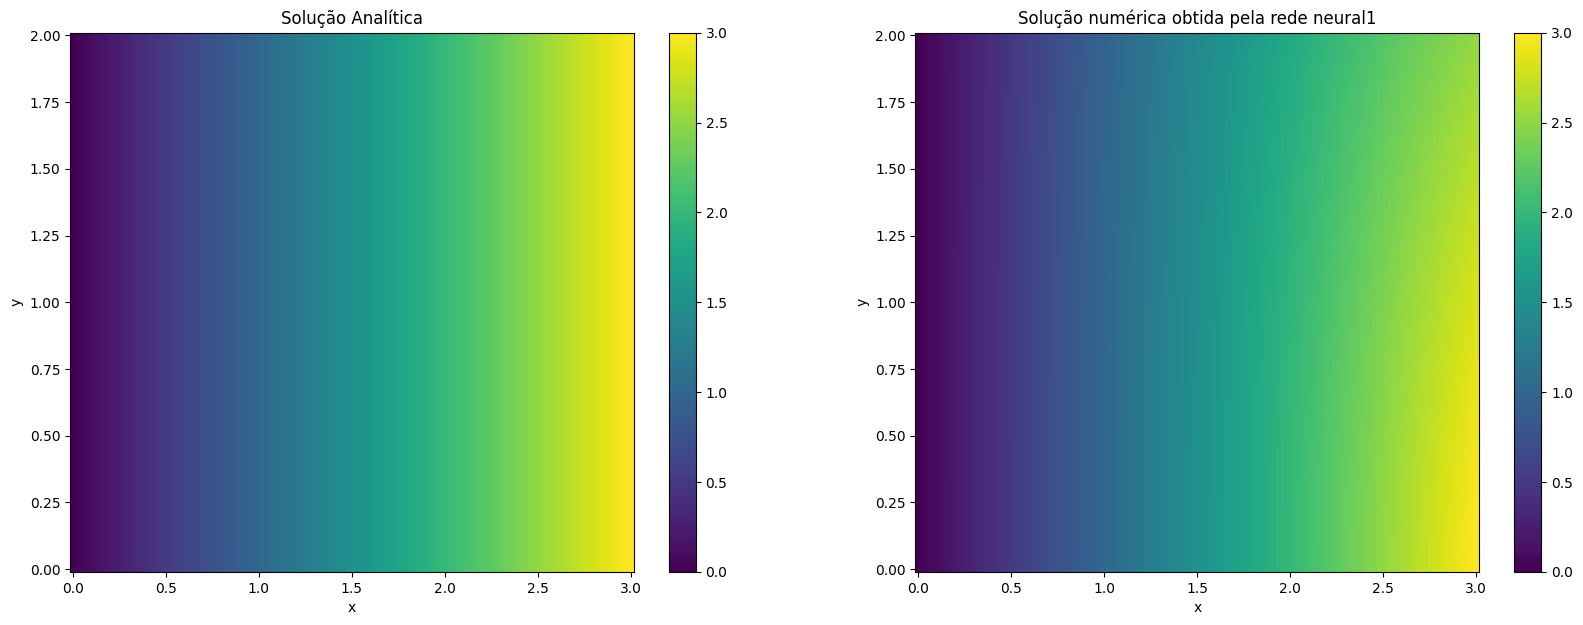

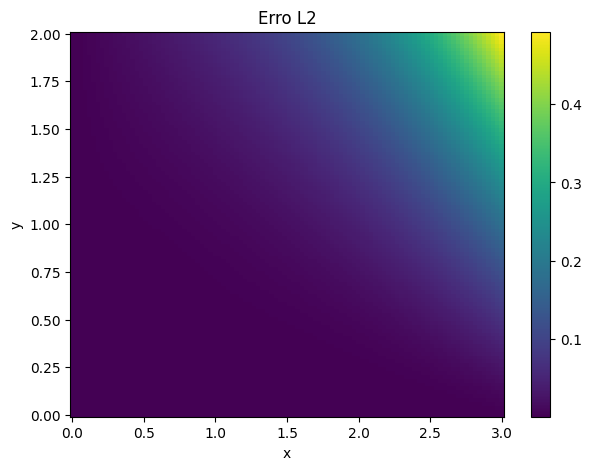

In [81]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_equacao_calor, a, b)

### Experimento 3

In [82]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=30,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossCalor(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [83]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.019953782167150103
Epoch 2000, Loss 0.005214195470301276
Epoch 3000, Loss 0.0019768840145022943
Epoch 4000, Loss 0.0005711783052742459
Epoch 5000, Loss 0.006794662037079775
Epoch 6000, Loss 0.00020295658255569863
Epoch 7000, Loss 9.632170075000062e-05
Epoch 8000, Loss 0.0001486917175778223
Epoch 9000, Loss 0.00010767565401665484
Epoch 10000, Loss 0.0003039936708621612
Epoch 11000, Loss 0.00012352123066820012
Epoch 12000, Loss 3.275792567823944e-05
Epoch 13000, Loss 8.43416555844158e-05
Epoch 14000, Loss 0.00022033440565527818
Epoch 15000, Loss 0.0002001643587993882
Epoch 16000, Loss 0.0017196795132588126
Epoch 17000, Loss 0.0018507223167700784
Epoch 18000, Loss 4.041727507898096e-05
Epoch 19000, Loss 0.00036851975958702125
Epoch 20000, Loss 0.00012155630081669508
Epoch 21000, Loss 0.0017385801389353968
Epoch 22000, Loss 1.0337104479433857e-05
Epoch 23000, Loss 0.0006083220242164823
Epoch 24000, Loss 0.0002666628610912145
Epoch 25000, Loss 6.076434243096435e-06
Epoch 

In [84]:
metricas(net, Loss.solucao_equacao_calor, a, b)

(tensor(0.0196), tensor(0.0785))

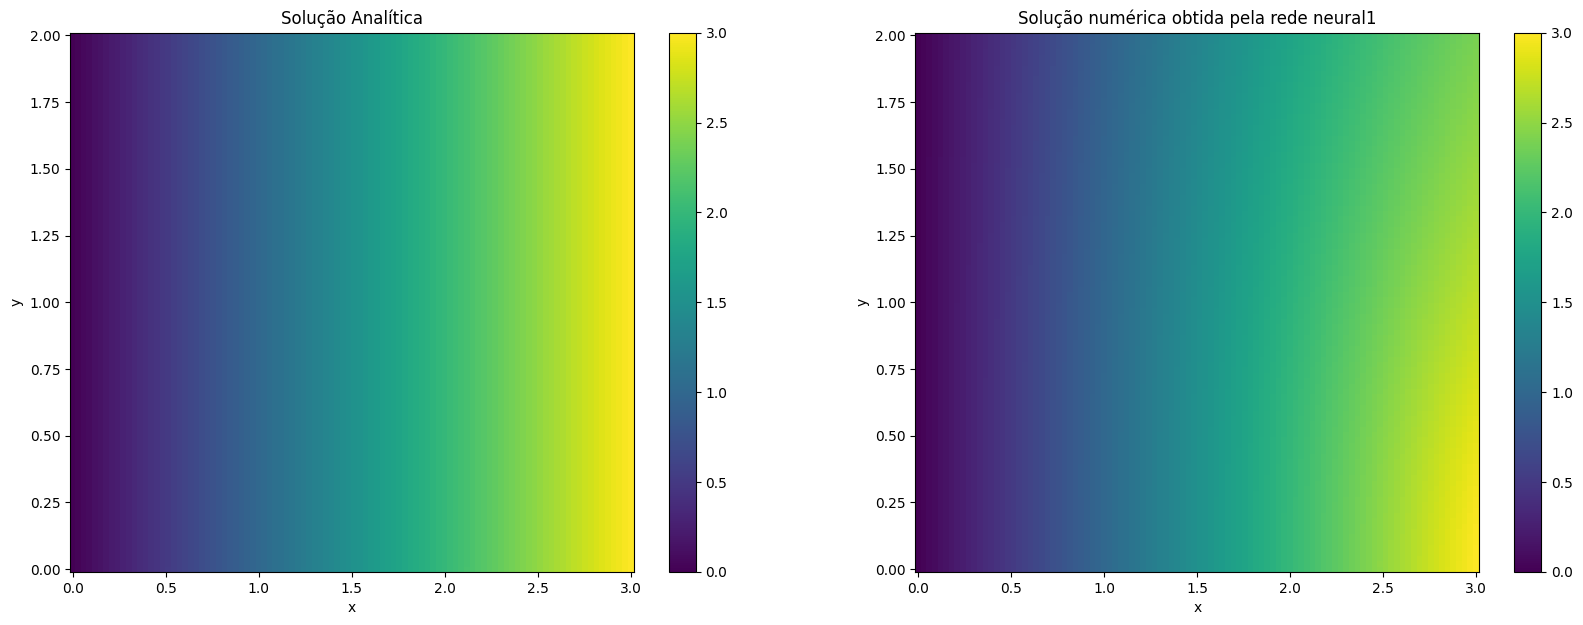

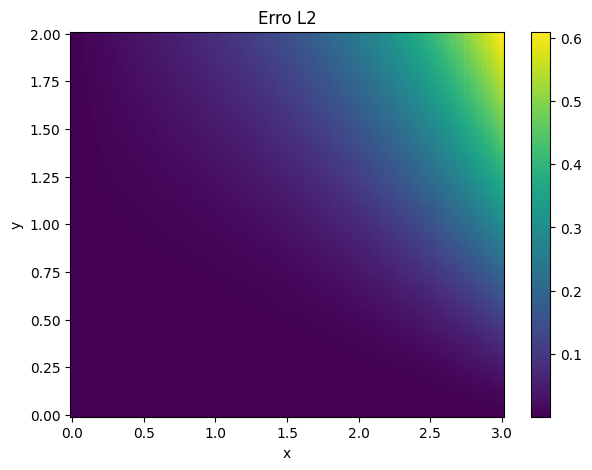

In [85]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_equacao_calor, a, b)

## Laplace

In [8]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 3
b = 2

x = np.random.uniform(0, a, size=L) ##
t = np.random.uniform(0, b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

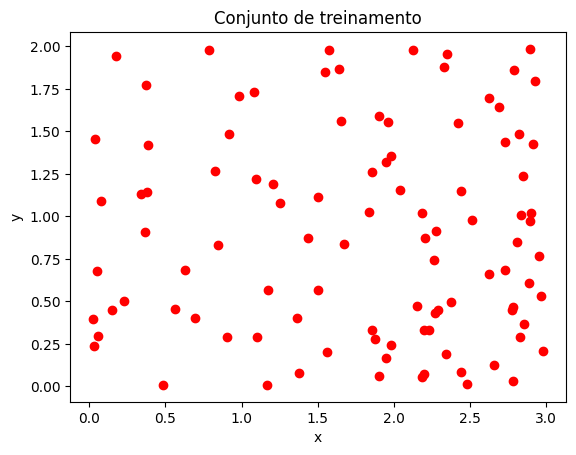

In [9]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [10]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Experimento 1

In [12]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=10,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossLaplace(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [13]:
epochs_array, loss_array = net.fit(x=inp, epochs=5000, nbatches=1, output_loss=True)

Epoch 1000, Loss 1.5463349336883825
Epoch 2000, Loss 0.2998830239799844
Epoch 3000, Loss 0.1082492261701065
Epoch 4000, Loss 0.05947835922088485
Epoch 5000, Loss 0.03973356334382111


In [14]:
metricas(net, Loss.solucao_laplace, a, b)

(tensor(1.0259e-05), tensor(0.0021))

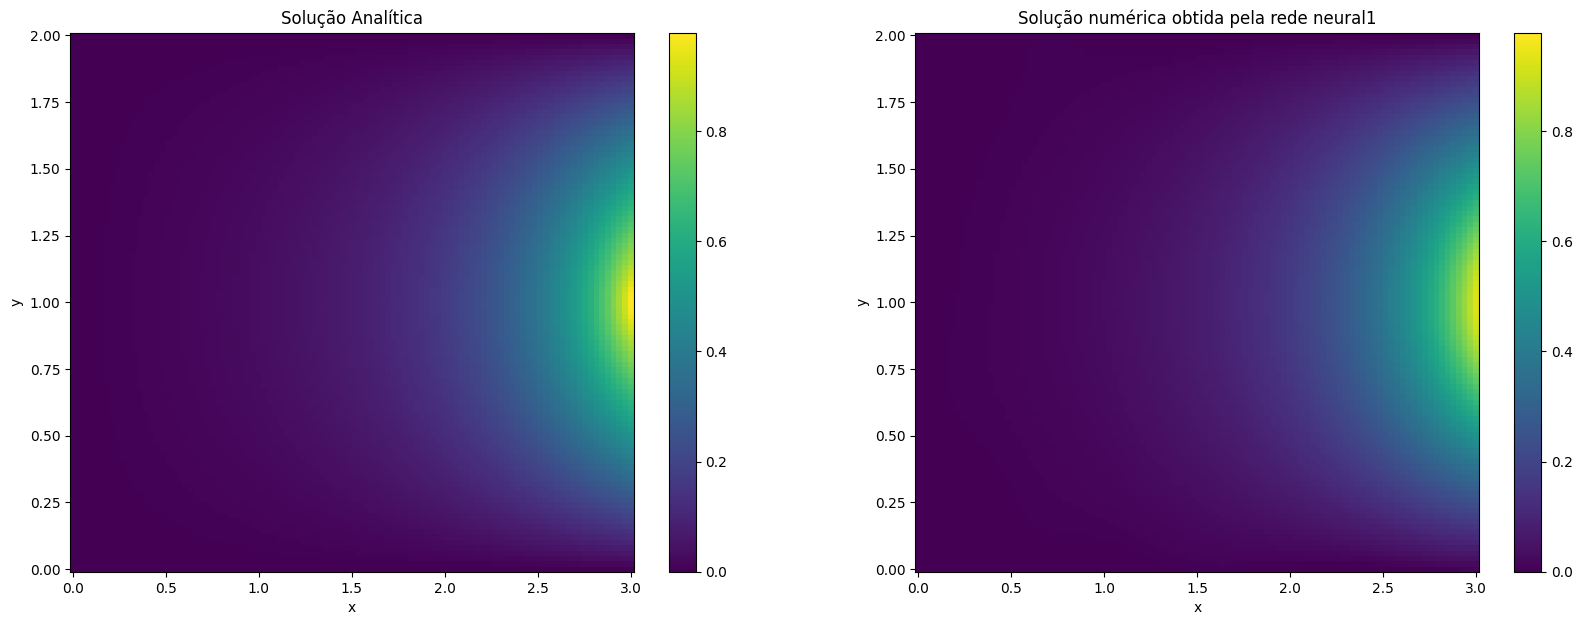

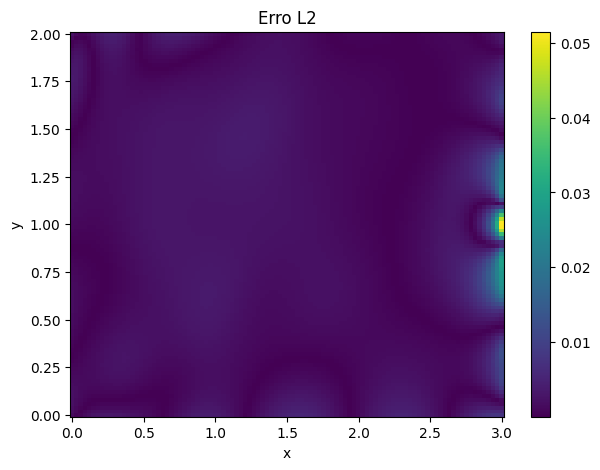

In [15]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_laplace, a, b)

### Experimento 2

In [94]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=20,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossLaplace(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [95]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.22652560570527047
Epoch 2000, Loss 0.04179818698222438
Epoch 3000, Loss 0.012826014902660863
Epoch 4000, Loss 0.011182610360497166
Epoch 5000, Loss 0.006767288496338376
Epoch 6000, Loss 0.0043822701477133335
Epoch 7000, Loss 0.0037354316223512716
Epoch 8000, Loss 0.0031973119727385845
Epoch 9000, Loss 0.002730354584441639
Epoch 10000, Loss 0.002351381629963431
Epoch 11000, Loss 0.008802492000005435
Epoch 12000, Loss 0.011037529007163522
Epoch 13000, Loss 0.0045696286734306
Epoch 14000, Loss 0.0016443876372389719
Epoch 15000, Loss 0.0015419652345822525
Epoch 16000, Loss 0.0021592338273392145
Epoch 17000, Loss 0.001583352975235475
Epoch 18000, Loss 0.00948780196052597
Epoch 19000, Loss 0.0012567143381460243
Epoch 20000, Loss 0.0012146342887871683
Epoch 21000, Loss 0.0012667715810803669
Epoch 22000, Loss 0.014433100747969956
Epoch 23000, Loss 0.002025425703682928
Epoch 24000, Loss 0.0012501212640104716
Epoch 25000, Loss 0.0011878549481092542
Epoch 26000, Loss 0.00104895

In [96]:
metricas(net, Loss.solucao_laplace, a, b)

(tensor(3.0410e-06), tensor(0.0009))

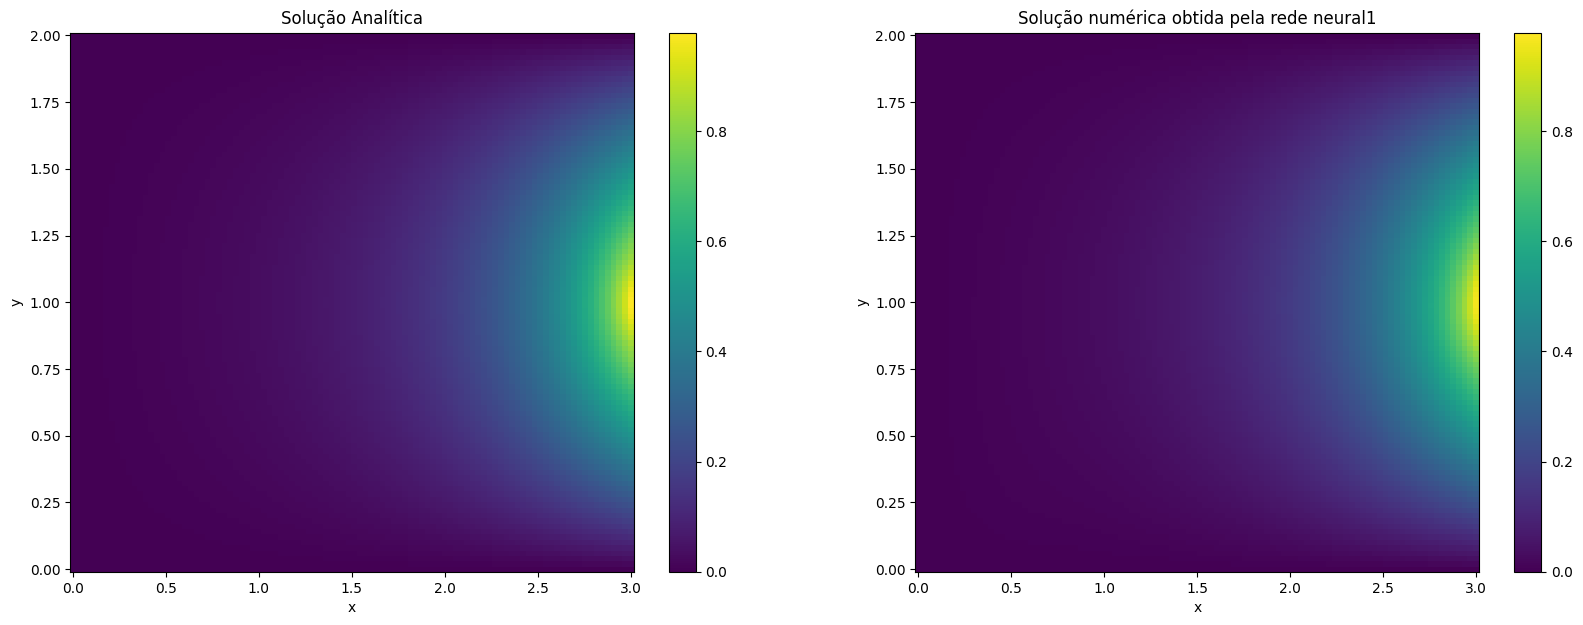

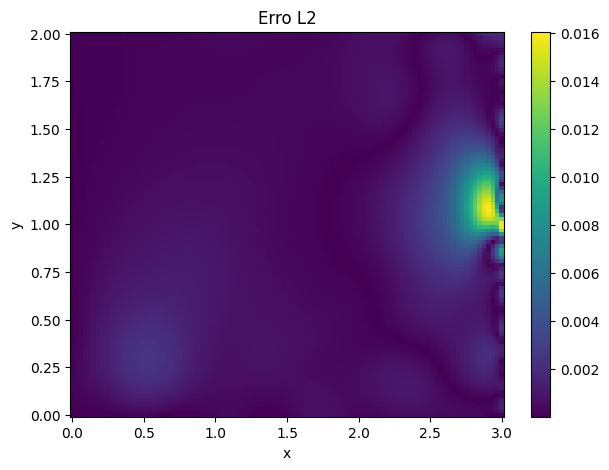

In [97]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_laplace, a, b)

### Experimento 3

In [98]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=30,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossLaplace(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [99]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.18335178348017334
Epoch 2000, Loss 0.031521693436320455
Epoch 3000, Loss 0.014004020324326088
Epoch 4000, Loss 0.005982747110335949
Epoch 5000, Loss 0.0035457941299704373
Epoch 6000, Loss 0.0024525315693435298
Epoch 7000, Loss 0.014275057927936818
Epoch 8000, Loss 0.0015853834134689276
Epoch 9000, Loss 0.00814190577303007
Epoch 10000, Loss 0.0009734093931449488
Epoch 11000, Loss 0.0020362779019211462
Epoch 12000, Loss 0.010140344165575516
Epoch 13000, Loss 0.005560414146518431
Epoch 14000, Loss 0.001220637476324127
Epoch 15000, Loss 0.0015146261720890163
Epoch 16000, Loss 0.0020925866928331984
Epoch 17000, Loss 0.0019677666049471416
Epoch 18000, Loss 0.0006294495789774734
Epoch 19000, Loss 0.0004582830392502563
Epoch 20000, Loss 0.0013254683981678344
Epoch 21000, Loss 0.009947149944401686
Epoch 22000, Loss 0.011188791006149541
Epoch 23000, Loss 0.0037909195101523303
Epoch 24000, Loss 0.00035936015097398307
Epoch 25000, Loss 0.0043635953976823745
Epoch 26000, Loss 0.0

In [100]:
metricas(net, Loss.solucao_laplace, a, b)

(tensor(1.4816e-05), tensor(0.0017))

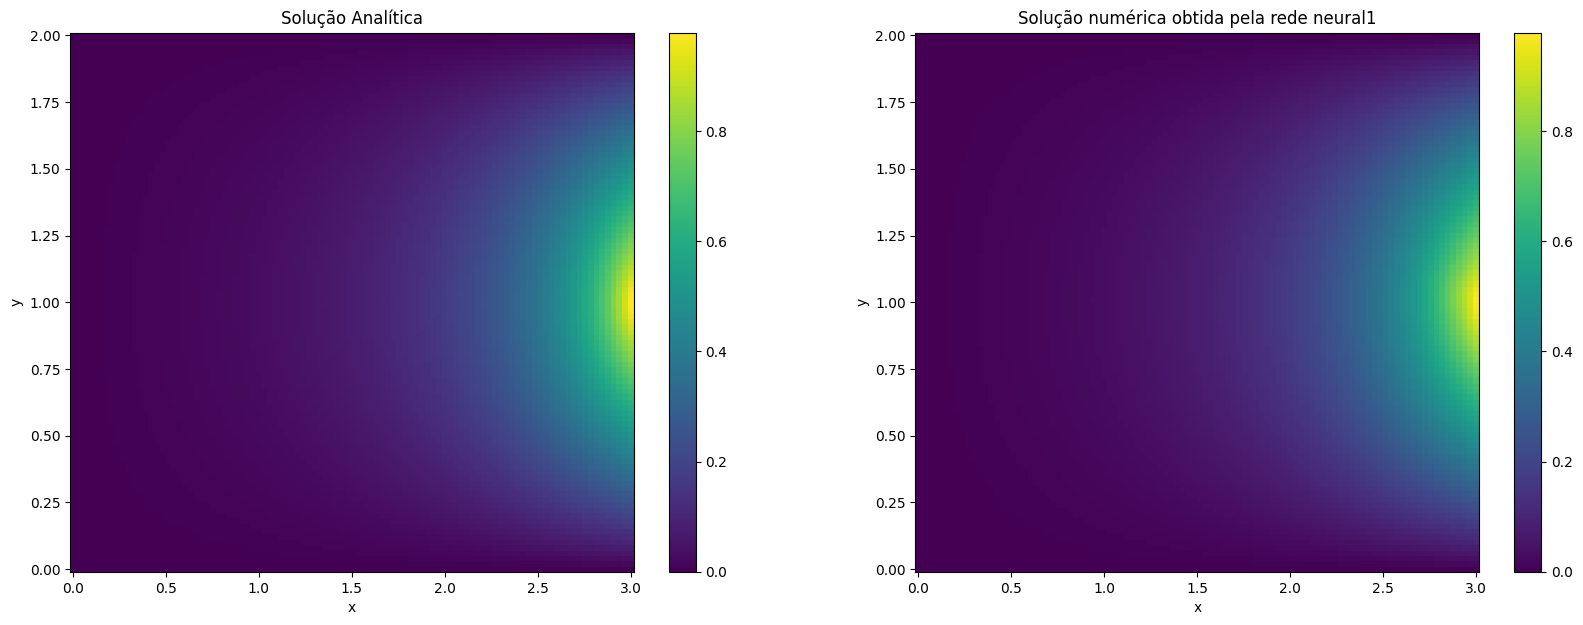

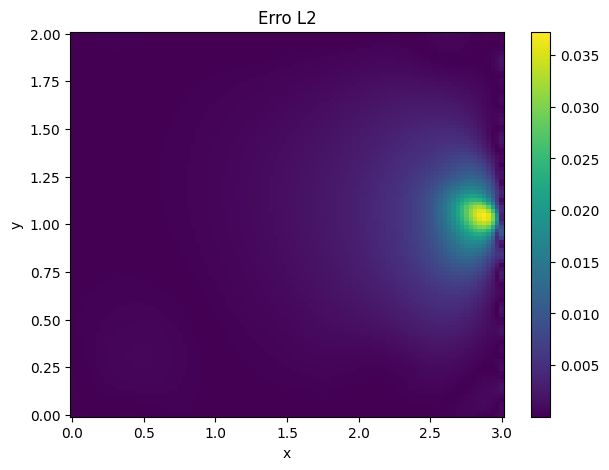

In [101]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_laplace, a, b)

## Laplace 2

In [102]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 3
b = 2

x = np.random.uniform(0, a, size=L) ##
t = np.random.uniform(0, b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

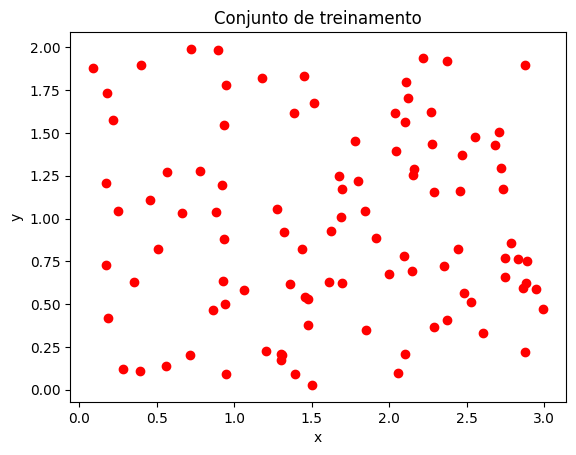

In [103]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [104]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [105]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Experimento 1

In [106]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=10,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossLaplace2(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [107]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 3845825459.36922
Epoch 2000, Loss 3765798698.115038
Epoch 3000, Loss 3690061628.9837627
Epoch 4000, Loss 3616963398.3194013
Epoch 5000, Loss 3550645926.326663
Epoch 6000, Loss 3488134386.5470266
Epoch 7000, Loss 3429644325.49704
Epoch 8000, Loss 3372113152.358477
Epoch 9000, Loss 3315734943.174552
Epoch 10000, Loss 3263974678.067168
Epoch 11000, Loss 3214483969.516525
Epoch 12000, Loss 3169622562.6425657
Epoch 13000, Loss 3124527114.7093744
Epoch 14000, Loss 3076206814.150793
Epoch 15000, Loss 3031382931.8789577
Epoch 16000, Loss 2989283770.616992
Epoch 17000, Loss 2949677802.9126816
Epoch 18000, Loss 2902343175.2913704
Epoch 19000, Loss 2864634957.0685873
Epoch 20000, Loss 2831150201.764814
Epoch 21000, Loss 2792294905.2460623
Epoch 22000, Loss 2762017715.0086927
Epoch 23000, Loss 2725460161.656872
Epoch 24000, Loss 2688303668.4065795
Epoch 25000, Loss 2655499865.8665743
Epoch 26000, Loss 2620891305.781945
Epoch 27000, Loss 2586018725.861676
Epoch 28000, Loss 25625007

In [108]:
metricas(net, Loss.solucao_laplace_2, a, b)

(tensor(989214.6477), tensor(686.5546))

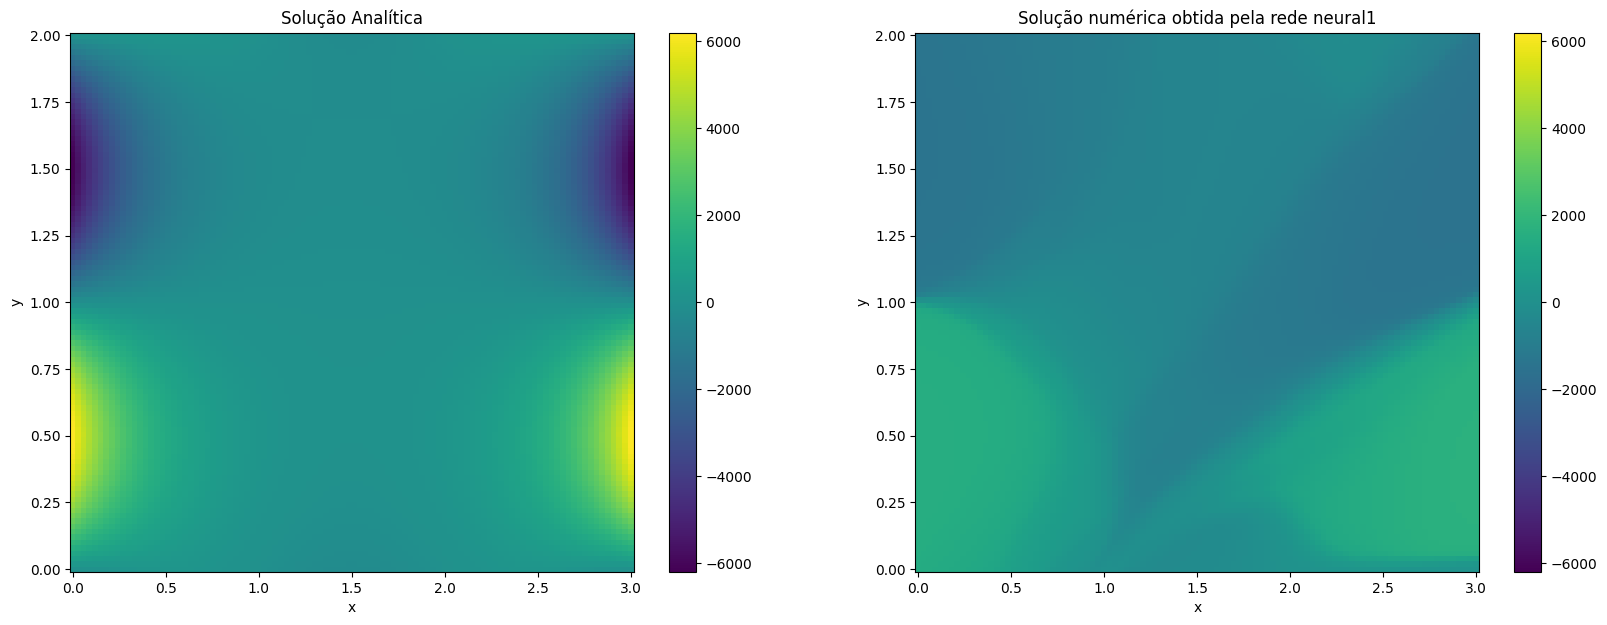

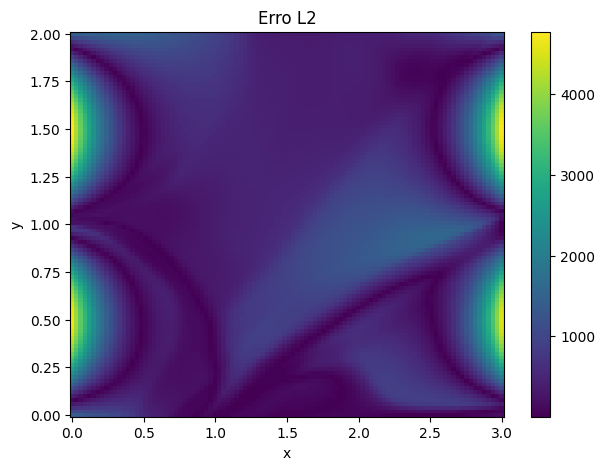

In [109]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_laplace_2, a, b)

### Experimento 2

In [110]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=20,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossLaplace(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [111]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.329651153946637
Epoch 2000, Loss 0.05491617753311544
Epoch 3000, Loss 0.009917679419412479
Epoch 4000, Loss 0.0045732074065455205
Epoch 5000, Loss 0.00322048098835809
Epoch 6000, Loss 0.003896254784367185
Epoch 7000, Loss 0.003114278763997244
Epoch 8000, Loss 0.0017842077951053142
Epoch 9000, Loss 0.0015735641587500623
Epoch 10000, Loss 0.0014375202011979336
Epoch 11000, Loss 0.0027655257442788994
Epoch 12000, Loss 0.004466331184633949
Epoch 13000, Loss 0.0016906050106089828
Epoch 14000, Loss 0.0011511674760344719
Epoch 15000, Loss 0.0021487741406106377
Epoch 16000, Loss 0.0010277915348310524
Epoch 17000, Loss 0.001379451468128872
Epoch 18000, Loss 0.0015330089712791931
Epoch 19000, Loss 0.00171065915398855
Epoch 20000, Loss 0.0030757557017693153
Epoch 21000, Loss 0.0008412890661380185
Epoch 22000, Loss 0.000867412866717352
Epoch 23000, Loss 0.0010774318165911946
Epoch 24000, Loss 0.0009328607524328462
Epoch 25000, Loss 0.0008399679420707694
Epoch 26000, Loss 0.00072

In [112]:
metricas(net, Loss.solucao_laplace_2, a, b)

(tensor(2200851.1452), tensor(870.7995))

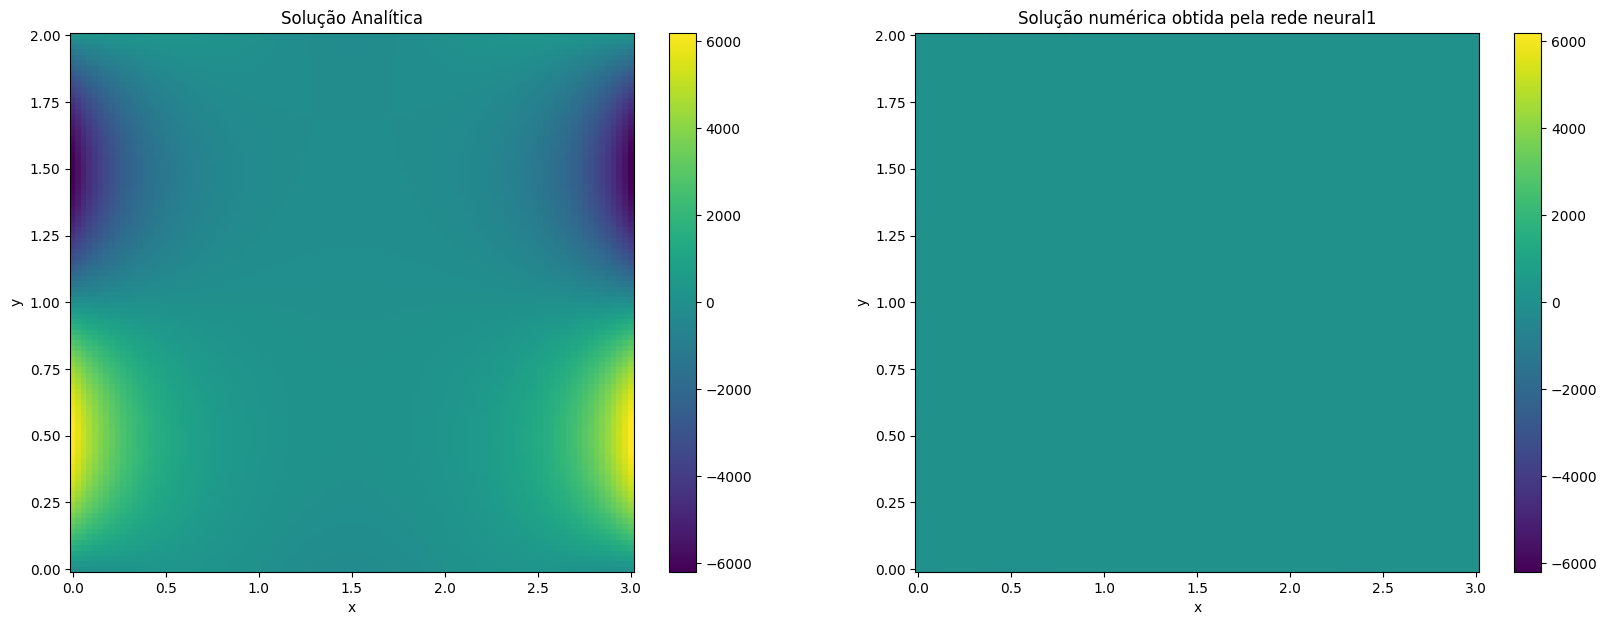

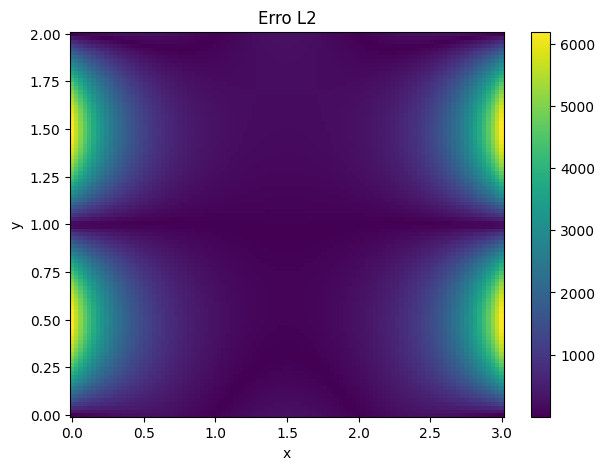

In [113]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_laplace_2, a, b)

### Experimento 3

In [114]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=30,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossLaplace2(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [115]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 3680751991.0945544
Epoch 2000, Loss 3471979858.2867393
Epoch 3000, Loss 3304450640.1146994
Epoch 4000, Loss 3150514309.6125174
Epoch 5000, Loss 3003795674.6730623
Epoch 6000, Loss 2882376728.074855
Epoch 7000, Loss 2752798279.0763273
Epoch 8000, Loss 2636830779.0257587
Epoch 9000, Loss 2526060371.897527
Epoch 10000, Loss 2426487880.1371584
Epoch 11000, Loss 2317363896.921421
Epoch 12000, Loss 2221615041.6395607
Epoch 13000, Loss 2135441960.2487288
Epoch 14000, Loss 2074276521.6707668
Epoch 15000, Loss 1989545833.9044902
Epoch 16000, Loss 1920263353.7411687
Epoch 17000, Loss 1853474530.1067615
Epoch 18000, Loss 1779975633.4112616
Epoch 19000, Loss 1723067935.5284443
Epoch 20000, Loss 1657713382.0540504
Epoch 21000, Loss 1605759534.869444
Epoch 22000, Loss 1543324218.8579698
Epoch 23000, Loss 1473811625.66553
Epoch 24000, Loss 1432811922.4581094
Epoch 25000, Loss 1385421065.622542
Epoch 26000, Loss 1327625470.6216154
Epoch 27000, Loss 1291591436.9885848
Epoch 28000, Loss

In [116]:
metricas(net, Loss.solucao_laplace_2, a, b)

(tensor(1239780.4022), tensor(813.1577))

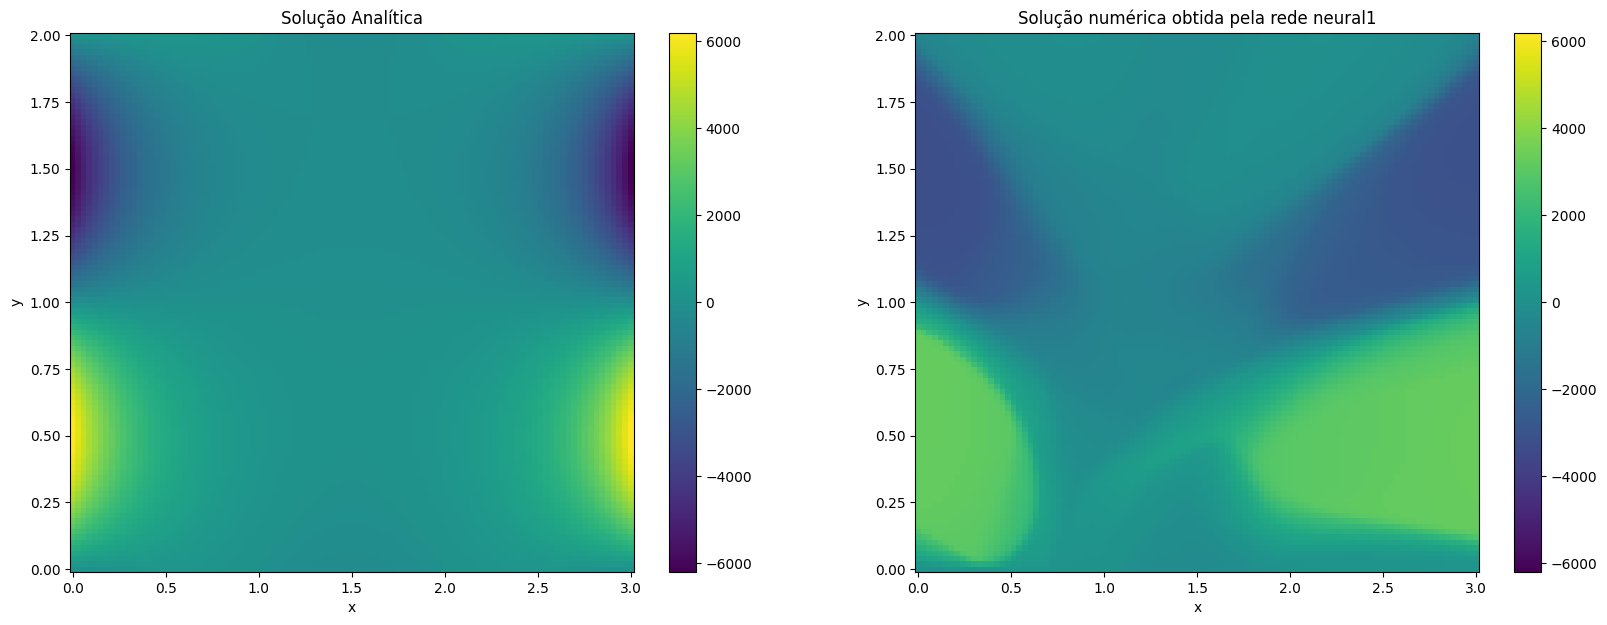

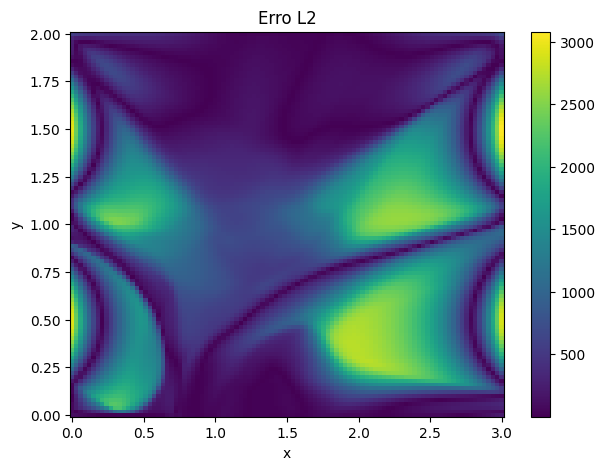

In [117]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_laplace_2, a, b)

## Laplace 3

In [118]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 1
b = 2

x = np.random.uniform(0, a, size=L) ##
t = np.random.uniform(0, b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

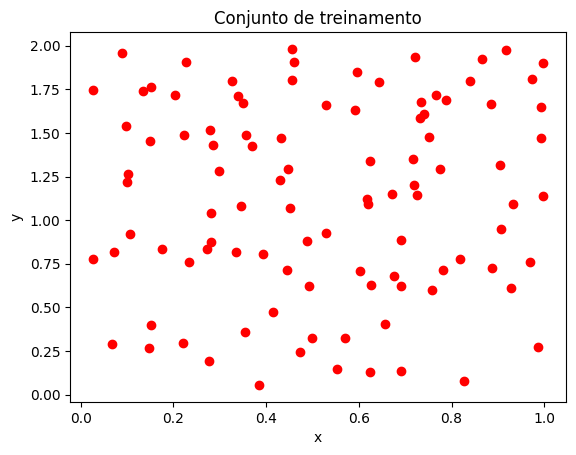

In [119]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [120]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [121]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Experimento 1

In [122]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=10,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossLaplace3(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [123]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.5614940858415393
Epoch 2000, Loss 0.10626014811807784
Epoch 3000, Loss 0.039722236832534855
Epoch 4000, Loss 0.015375610910816831
Epoch 5000, Loss 0.007360965368091404
Epoch 6000, Loss 0.00433933867865261
Epoch 7000, Loss 0.002982689371122081
Epoch 8000, Loss 0.0022422046984546576
Epoch 9000, Loss 0.0017866030703057967
Epoch 10000, Loss 0.0014879990268138689
Epoch 11000, Loss 0.0012843161977272582
Epoch 12000, Loss 0.0011420299528830853
Epoch 13000, Loss 0.001414244105163599
Epoch 14000, Loss 0.0009167134980459725
Epoch 15000, Loss 0.0009584813584677983
Epoch 16000, Loss 0.0007518319718514411
Epoch 17000, Loss 0.0012082910433907116
Epoch 18000, Loss 0.004398104819736211
Epoch 19000, Loss 0.0007836793596683968
Epoch 20000, Loss 0.010144765137558947
Epoch 21000, Loss 0.0005241228864771447
Epoch 22000, Loss 0.0004925246911222956
Epoch 23000, Loss 0.005989159762564508
Epoch 24000, Loss 0.0004542324435446232
Epoch 25000, Loss 0.0008051827052935255
Epoch 26000, Loss 0.0004

In [124]:
metricas(net, Loss.solucao_laplace_3, a, b)

(tensor(4.7299e-08), tensor(0.0001))

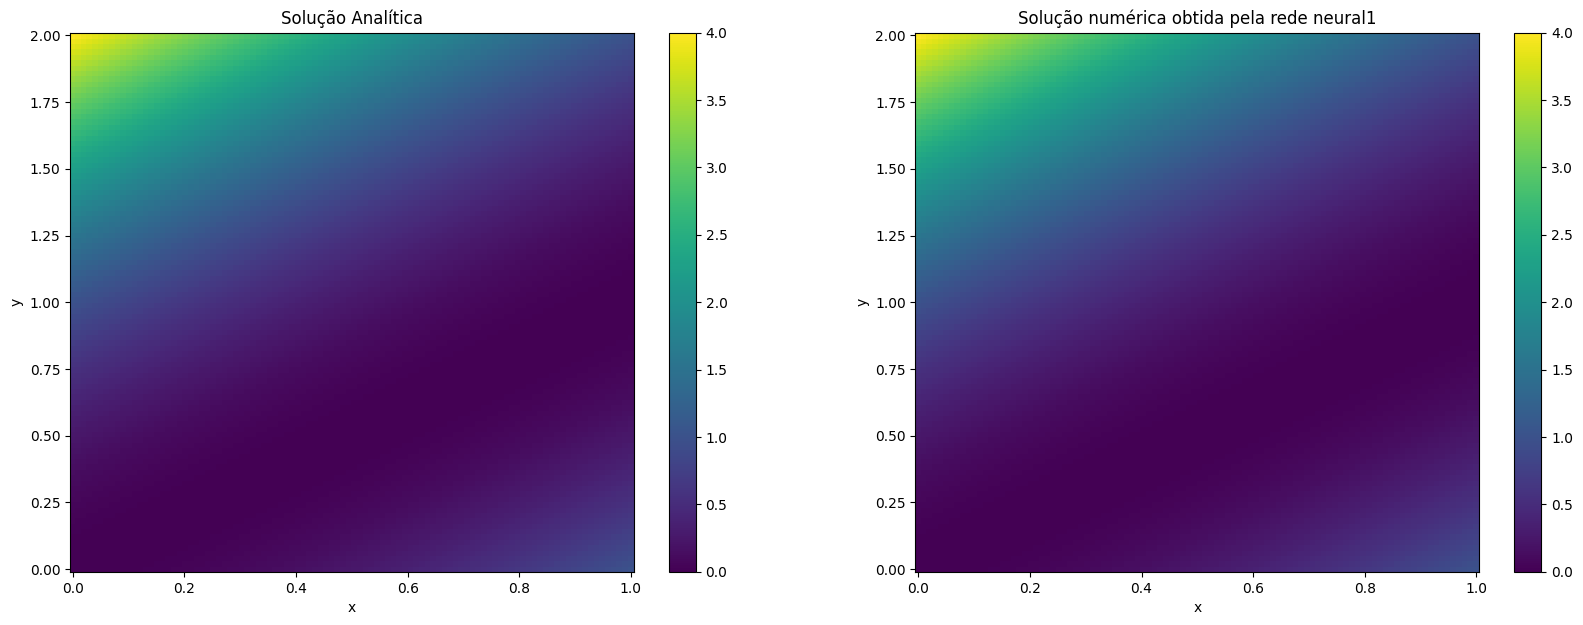

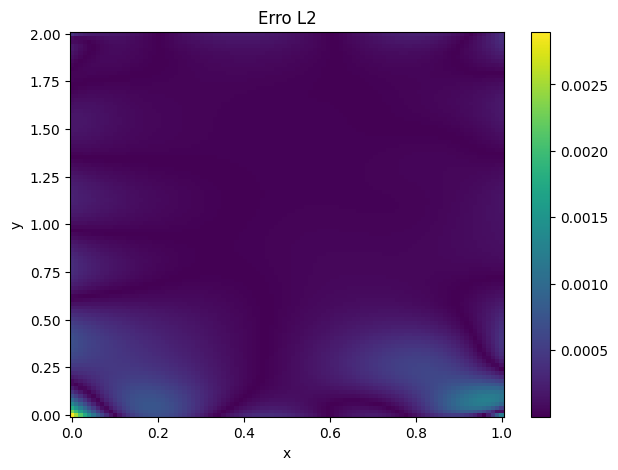

In [125]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_laplace_3, a, b)

### Experimento 2

In [126]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=20,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossLaplace3(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [127]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.27114926081878626
Epoch 2000, Loss 0.04544852004208736
Epoch 3000, Loss 0.01095604562994328
Epoch 4000, Loss 0.004192846481143379
Epoch 5000, Loss 0.018599738380036767
Epoch 6000, Loss 0.0011545553351728329
Epoch 7000, Loss 0.0007478581984555436
Epoch 8000, Loss 0.00979453790950945
Epoch 9000, Loss 0.003403976990938265
Epoch 10000, Loss 0.0007408669036330735
Epoch 11000, Loss 0.00038902510897855273
Epoch 12000, Loss 0.003499122150454354
Epoch 13000, Loss 0.000330708395243413
Epoch 14000, Loss 0.013737338381411168
Epoch 15000, Loss 0.010257080849476888
Epoch 16000, Loss 0.00031769118018793965
Epoch 17000, Loss 0.0025195716351345356
Epoch 18000, Loss 0.00018669976778459303
Epoch 19000, Loss 0.0003195942035133253
Epoch 20000, Loss 0.008613739680491934
Epoch 21000, Loss 0.00015884886111178833
Epoch 22000, Loss 0.0003880720599354721
Epoch 23000, Loss 0.00013351883026031314
Epoch 24000, Loss 0.00012735801922798598
Epoch 25000, Loss 0.00019814215074209944
Epoch 26000, Loss 

In [128]:
metricas(net, Loss.solucao_laplace_3, a, b)

(tensor(9.0495e-09), tensor(6.5812e-05))

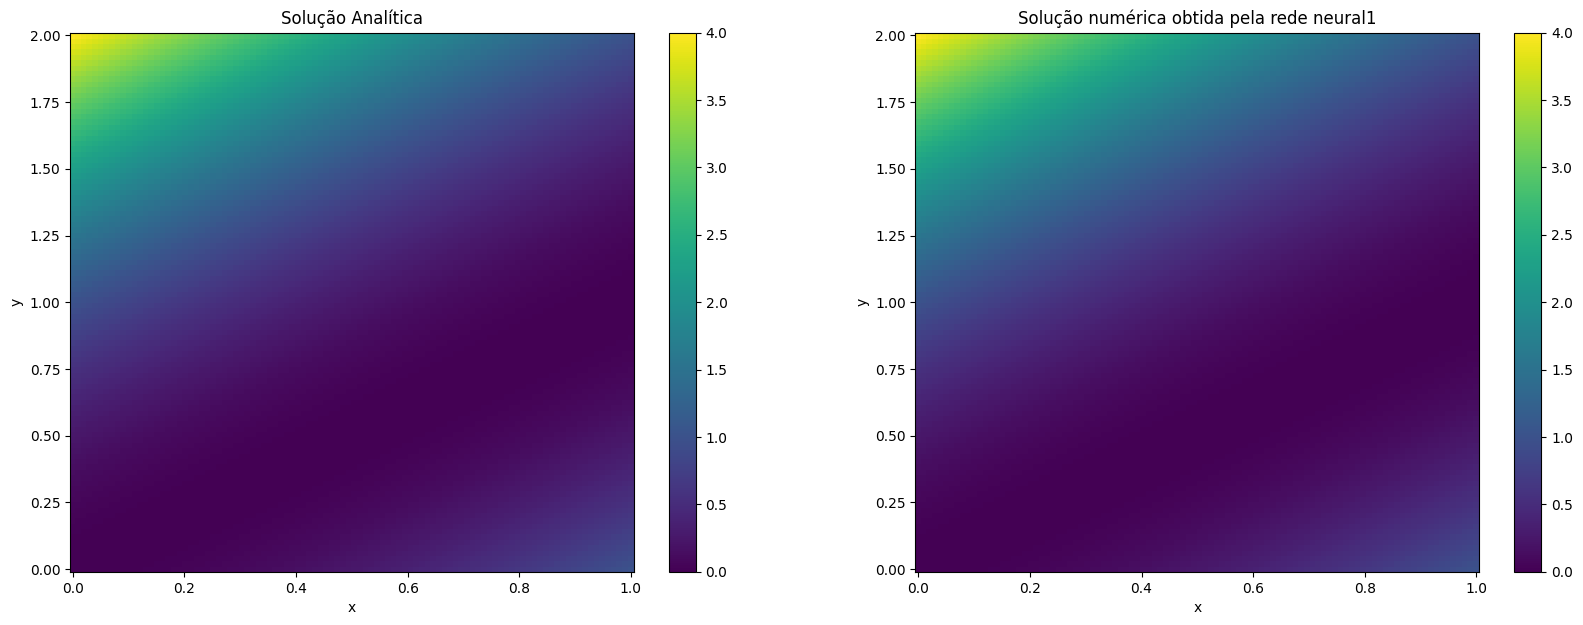

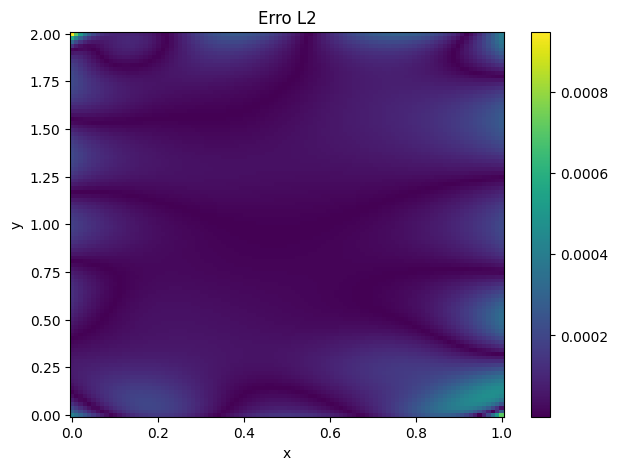

In [129]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_laplace_3, a, b)

### Experimento 3

In [130]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=30,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossLaplace3(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [131]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.14289140695954436
Epoch 2000, Loss 0.05797572649755229
Epoch 3000, Loss 0.021115542428627402
Epoch 4000, Loss 0.006257743042175368
Epoch 5000, Loss 0.002129460069185198
Epoch 6000, Loss 0.0010871004710832387
Epoch 7000, Loss 0.0007154978586982238
Epoch 8000, Loss 0.0009215264165243366
Epoch 9000, Loss 0.00041369674739842664
Epoch 10000, Loss 0.07172108452195747
Epoch 11000, Loss 0.0013863481421160645
Epoch 12000, Loss 0.00030387353014733355
Epoch 13000, Loss 0.0004202811975033468
Epoch 14000, Loss 0.003121823982239316
Epoch 15000, Loss 0.0022323281795311395
Epoch 16000, Loss 0.0001454816006747647
Epoch 17000, Loss 0.020938798015747766
Epoch 18000, Loss 0.00018173751549056054
Epoch 19000, Loss 0.02266309042208377
Epoch 20000, Loss 0.00011361470434762454
Epoch 21000, Loss 0.0007887360047198688
Epoch 22000, Loss 0.0012886979356789778
Epoch 23000, Loss 0.03934756769366442
Epoch 24000, Loss 0.00023549012989820245
Epoch 25000, Loss 8.981729772231698e-05
Epoch 26000, Loss 8

In [132]:
metricas(net, Loss.solucao_laplace_3, a, b)

(tensor(1.6523e-08), tensor(9.1000e-05))

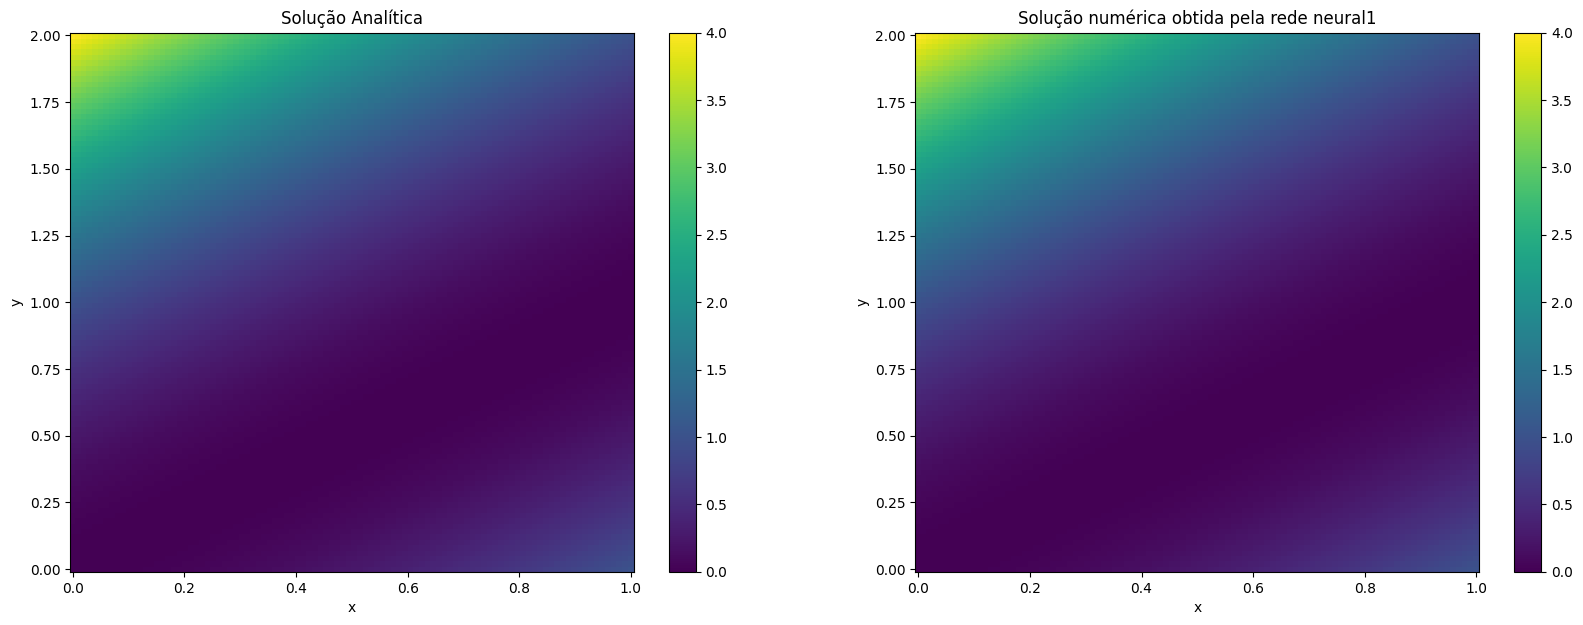

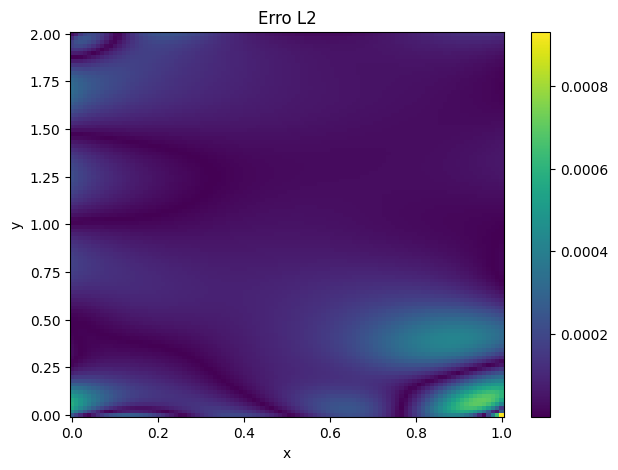

In [133]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_laplace_3, a, b)

## Trasnporte

In [134]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 1
b = 1

x = np.random.uniform(0, a, size=L) ##
t = np.random.uniform(0, b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

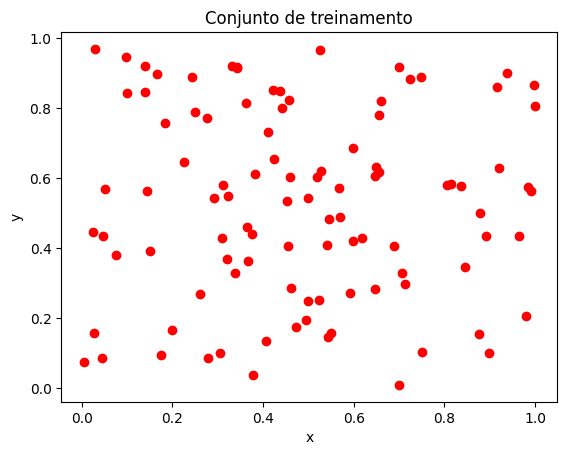

In [135]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [136]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [137]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Experimento 1

In [138]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=10,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossTransporte(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [139]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.05101412348403943
Epoch 2000, Loss 0.017920274071190692
Epoch 3000, Loss 0.004212051266031728
Epoch 4000, Loss 0.0014399530538736823
Epoch 5000, Loss 0.0004822685627271001
Epoch 6000, Loss 0.000297790737333918
Epoch 7000, Loss 9.07741757543066e-05
Epoch 8000, Loss 4.642484352578245e-05
Epoch 9000, Loss 2.9480218458058445e-05
Epoch 10000, Loss 2.2125208742898146e-05
Epoch 11000, Loss 1.8085490952950634e-05
Epoch 12000, Loss 1.6447468711933368e-05
Epoch 13000, Loss 1.395692788923191e-05
Epoch 14000, Loss 2.249605629839063e-05
Epoch 15000, Loss 1.1676135329740706e-05
Epoch 16000, Loss 2.199193966311956e-05
Epoch 17000, Loss 0.00013780479195687025
Epoch 18000, Loss 1.9604940127603967e-05
Epoch 19000, Loss 8.786894051973138e-06
Epoch 20000, Loss 8.866005164324918e-06
Epoch 21000, Loss 9.677140750048033e-05
Epoch 22000, Loss 7.920899909093541e-06
Epoch 23000, Loss 6.951241138572397e-06
Epoch 24000, Loss 8.542988944325428e-06
Epoch 25000, Loss 0.00020304227895218244
Epoch 2

In [140]:
metricas(net, Loss.solucao_transporte, a, b)

(tensor(0.0333), tensor(0.0883))

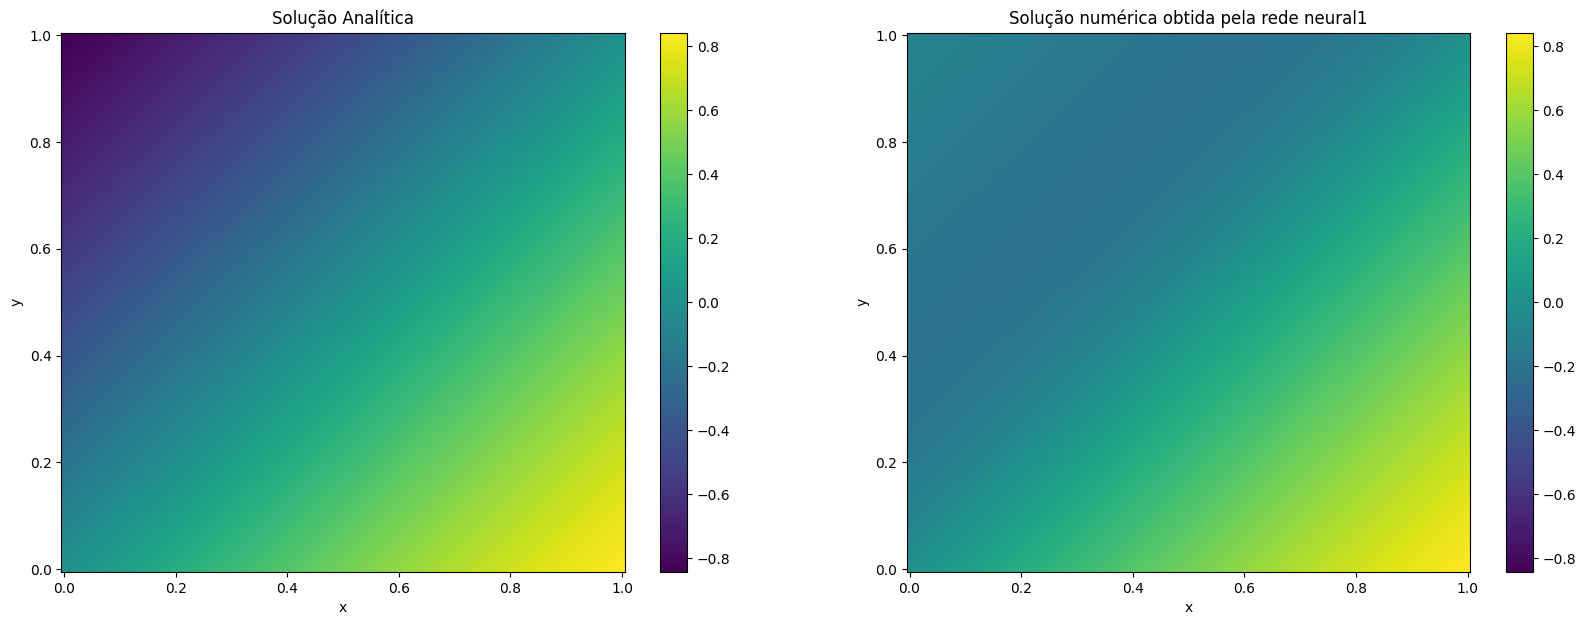

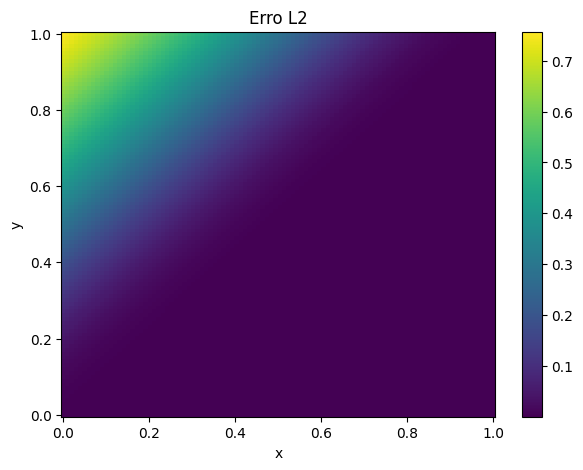

In [141]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_transporte, a, b)

### Experimento 2

In [142]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=20,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossTransporte(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [143]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.01956326904416053
Epoch 2000, Loss 0.0033845057605066445
Epoch 3000, Loss 0.0007860862638802977
Epoch 4000, Loss 0.00026767653633549696
Epoch 5000, Loss 7.024390479933185e-05
Epoch 6000, Loss 0.00026787594385639505
Epoch 7000, Loss 2.2356928508676013e-05
Epoch 8000, Loss 1.498630529993648e-05
Epoch 9000, Loss 0.00029205329572551473
Epoch 10000, Loss 8.667330722374274e-06
Epoch 11000, Loss 6.384666524288592e-06
Epoch 12000, Loss 5.468262263720864e-06
Epoch 13000, Loss 0.0005066969585918685
Epoch 14000, Loss 0.0005560397098864607
Epoch 15000, Loss 3.5340785162206815e-06
Epoch 16000, Loss 4.358746912190566e-05
Epoch 17000, Loss 2.9694957338773565e-06
Epoch 18000, Loss 3.365453382363081e-06
Epoch 19000, Loss 5.61497705128066e-06
Epoch 20000, Loss 3.3092960811409246e-06
Epoch 21000, Loss 1.3203934907691965e-05
Epoch 22000, Loss 2.875315358338394e-06
Epoch 23000, Loss 4.046505973312909e-05
Epoch 24000, Loss 1.9444069360147927e-06
Epoch 25000, Loss 2.024974129572694e-06
Epo

In [144]:
metricas(net, Loss.solucao_transporte, a, b)

(tensor(0.0191), tensor(0.0609))

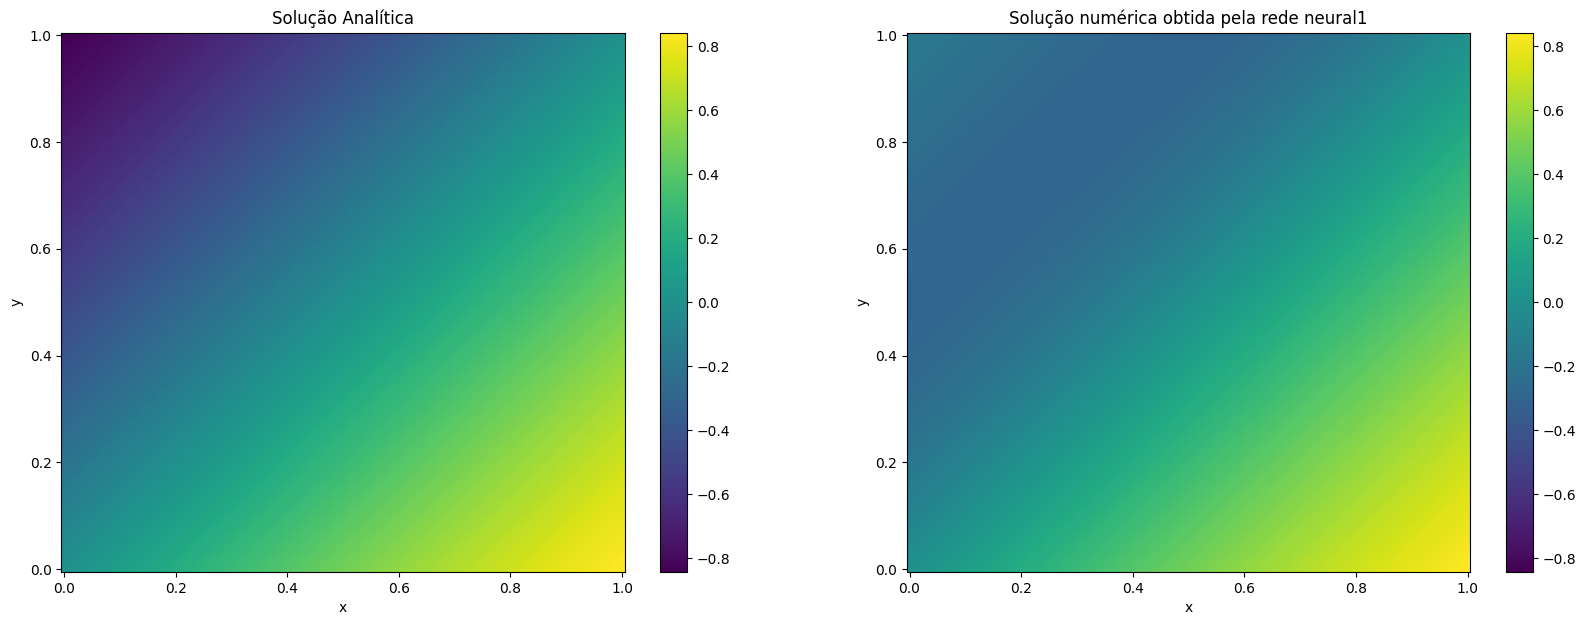

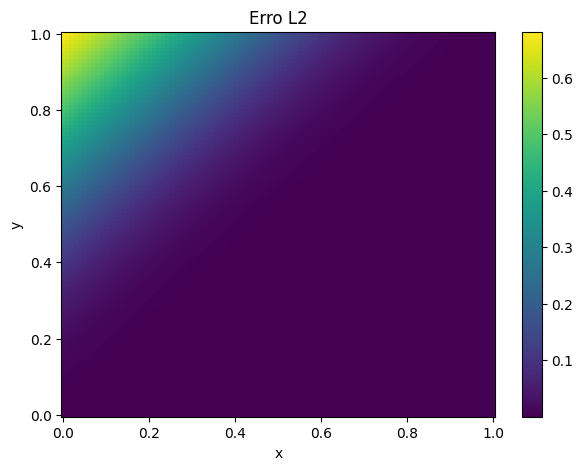

In [145]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_transporte, a, b)

### Experimento 3

In [146]:
net = Net.Net_DGM(n_input=2,
                  n_neurons=30,
                  n_layers=3,
                  activation_functions=nn.Tanh,
                  loss=Loss.LossTransporte(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
                  loss_params={},
                  optimizer=optim.Adamax,
                  optimizer_params={'lr': 0.001})


In [147]:
epochs_array, loss_array = net.fit(x=inp, epochs=50000, nbatches=1, output_loss=True)

Epoch 1000, Loss 0.009174511728811702
Epoch 2000, Loss 0.002141939471186031
Epoch 3000, Loss 0.0005864628097032858
Epoch 4000, Loss 0.00029573650122782216
Epoch 5000, Loss 7.317018365347423e-05
Epoch 6000, Loss 3.968805548568939e-05
Epoch 7000, Loss 2.5805178820816032e-05
Epoch 8000, Loss 2.610305478988185e-05
Epoch 9000, Loss 3.0816964192251835e-05
Epoch 10000, Loss 3.981069177933168e-05
Epoch 11000, Loss 1.1413992944727777e-05
Epoch 12000, Loss 1.2807411083043683e-05
Epoch 13000, Loss 1.0040612402796684e-05
Epoch 14000, Loss 8.256315717046897e-06
Epoch 15000, Loss 0.00015457864329792423
Epoch 16000, Loss 9.600664856674064e-06
Epoch 17000, Loss 6.31395918410707e-06
Epoch 18000, Loss 5.965542707808184e-06
Epoch 19000, Loss 5.716838208157246e-06
Epoch 20000, Loss 5.4192517520252545e-06
Epoch 21000, Loss 5.117875259383341e-06
Epoch 22000, Loss 5.673138193358306e-06
Epoch 23000, Loss 0.0002178117449557342
Epoch 24000, Loss 1.979994252686123e-05
Epoch 25000, Loss 8.300342228048553e-06
Epoc

In [148]:
metricas(net, Loss.solucao_transporte, a, b)

(tensor(0.0210), tensor(0.0677))

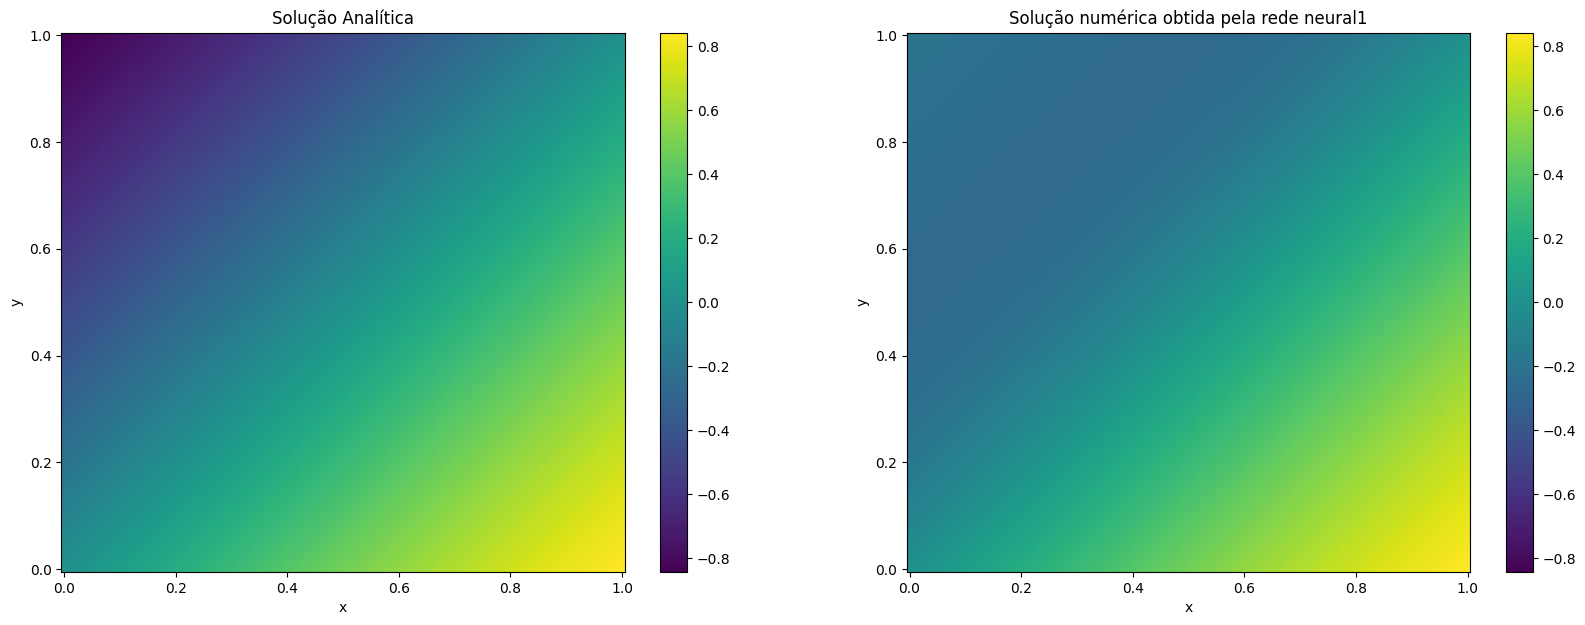

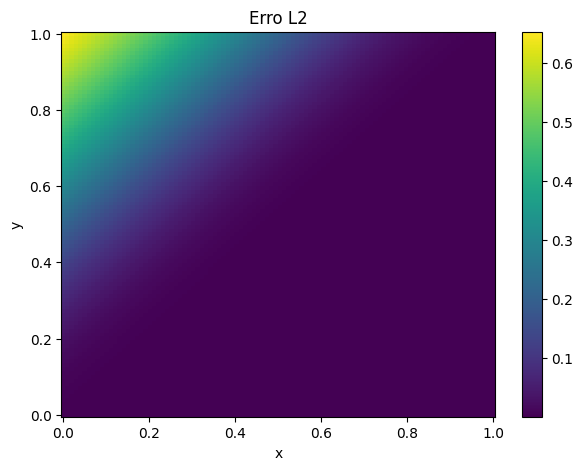

In [149]:
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solucao_transporte, a, b)